### Imports

In [172]:
import numpy as np
import pandas as pd
import string
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, RegressorMixin  # so our yagdi can function with pipeline
from sklearn.metrics import mean_squared_error
from sklearn.utils import resample
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

### Functions

In [ ]:
### Hardcoded Values
traintestrat = 0.2    # train-test split ratio
interceptFit = False  #exclude intercept in polynomial fit
figpath = '<>\Projects\project1_figures'

In [174]:
def polynomial_features(x, p, intercept=False):
    x = np.array(x) # so x is np.array and not list
    startat = 0 if intercept else 1
    return np.vstack([x**i for i in range(startat, p+1)]).T

def OLS_params(X, y):
    # return np.linalg.inv(X.T @ X) @ X.T @ y
    return np.linalg.pinv(X.T @ X) @ X.T @ y

def MSE(y_dat, y_model):
    n = np.size(y_model)
    return np.sum((y_dat-y_model)**2)/n

def Rsquared(y_dat, y_model):
    y_mean = np.mean(y_dat)
    return 1 - np.sum((y_dat-y_model)**2) / np.sum((y_dat-y_mean)**2)

def Ridge_params(X, y, l=None):
    # Assumes X is scaled and has no intercept column
    if not l:
        l = np.median(X.T @ X )/X.shape[1]
    # return np.linalg.inv(X.T @ X + l*np.eye(X.shape[1])) @ X.T @ y
    return np.linalg.pinv(X.T @ X + l*np.eye(X.shape[1])) @ X.T @ y

def runge_function(N, noise=True):
    #define runge function in the given interval with stochastic noise following N(0,1)
    x = np.linspace(-1, 1, N)
    y = 1/(1+25*x**2) 
    if noise:
        y += np.random.normal(0, 0.1, size=N) 
    return x, y 

def pre_processing(x, y, N, P):
    # Feature Scaling
    FM = polynomial_features(x, P, intercept=interceptFit)
    FM_mean = FM.mean(axis=0)
    FM_std = FM.std(axis=0)
    FM_std[FM_std == 0] = 1  # safeguard to avoid division by zero for constant features
    FM_sc = (FM - FM_mean) / FM_std
    # Get Hessian Eigenvalues 
    H = (2.0/N) *FM_sc.T @ FM_sc
    EigValues = np.linalg.eig(H)[0]
    max_eig = np.max(EigValues)
    
    # Sclae Data
    X_train, X_test, y_train, y_test, x_train, x_test = train_test_split(FM_sc, y, x, test_size=traintestrat)
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    y_offset = np.mean(y_train)
    y_sc = y_train - y_offset
    return X_train_scaled, X_test_scaled, x_train, x_test, y_sc, y_offset, y_test, max_eig   # substract offset when training, add it again for both test and train evaluation
    
def ols_analysis(X_train_scaled, X_test_scaled, y_sc, y_offset, y_test):                 
    theta_OLS = OLS_params(X_train_scaled, y_sc)
    y_train_pred = X_train_scaled @ theta_OLS + y_offset
    y_test_pred = X_test_scaled @ theta_OLS + y_offset 
    return theta_OLS, MSE(y_sc+y_offset, y_train_pred), MSE(y_test, y_test_pred), Rsquared(y_sc+y_offset, y_train_pred), Rsquared(y_test, y_test_pred)
    
def ridge_analysis(X_train_scaled, X_test_scaled, y_sc, y_offset, y_test, l_val):
    theta_ridge = Ridge_params(X_train_scaled, y_sc, l=l_val)
    y_train_pred = X_train_scaled @ theta_ridge + y_offset
    y_test_pred = X_test_scaled @ theta_ridge + y_offset 
    return theta_ridge, MSE(y_sc+y_offset, y_train_pred), MSE(y_test, y_test_pred), Rsquared(y_sc+y_offset, y_train_pred), Rsquared(y_test, y_test_pred)

### part A

### Testing R2 and MSE for OLS Noiseless and With Noise **N=100**

In [175]:
N = 100
P = 15
degree_vec = np.arange(1, P+1)

MSE_train = []
MSE_test = []
Rsquared_train = []
Rsquared_test = []

MSE_train_withnoise = []
MSE_test_withnoise = []
Rsquared_train_withnoise = []
Rsquared_test_withnoise = []

# Noiseless
x, y = runge_function(N, noise=False)
for degree in degree_vec:
    X_train_scaled, X_test_scaled, pip, pip, y_sc, y_offset, y_test, max_eig = pre_processing(x, y, N, degree)
    theta_ols, mse_train_ols, mse_test_ols, r2_train_ols, r2_test_ols = ols_analysis(X_train_scaled, X_test_scaled, y_sc, y_offset, y_test)
    MSE_train.append(mse_train_ols)
    MSE_test.append(mse_test_ols)
    Rsquared_train.append(r2_train_ols)
    Rsquared_test.append(r2_test_ols)
theta_lowOrder = theta_ols[0]
theta_highOrder = theta_ols[-1]

# With Noise (_wn)
x, y = runge_function(N, noise=True)
for degree in degree_vec:
    X_train_scaled, X_test_scaled, pip, pip, y_sc, y_offset, y_test, max_eig = pre_processing(x, y, N, degree)
    theta_ols_wn, mse_train_ols_wn, mse_test_ols_wn, r2_train_ols_wn, r2_test_ols_wn = ols_analysis(X_train_scaled, X_test_scaled, y_sc, y_offset, y_test)
    MSE_train_withnoise.append(mse_train_ols_wn)
    MSE_test_withnoise.append(mse_test_ols_wn)
    Rsquared_train_withnoise.append(r2_train_ols_wn)
    Rsquared_test_withnoise.append(r2_test_ols_wn)
theta_lowOrder_wn = theta_ols_wn[0]
theta_highOrder_wn = theta_ols_wn[-1]

In [176]:
# Test How Prediction is affected by Noise (lowst and highest order parameter)
print(theta_lowOrder)
print(theta_lowOrder_wn)
print(theta_highOrder)
print(theta_highOrder_wn)

0.0065557692740951246
0.27277903222955546
20.37451929901367
-28.030198994072563


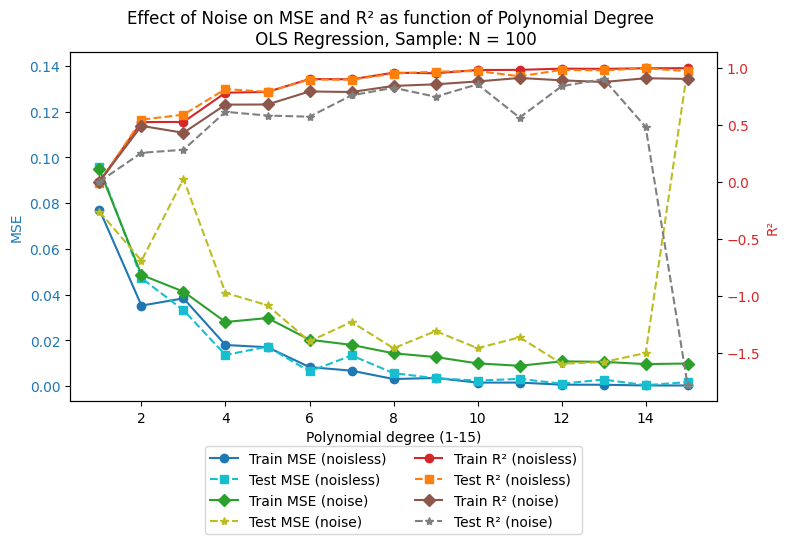

In [177]:
fig, ax1 = plt.subplots(figsize=(8, 6))

# left y-side: MSE
ax1.plot(degree_vec, MSE_train, 'o-', label='Train MSE (noisless)', color='tab:blue')
ax1.plot(degree_vec, MSE_test, 's--', label='Test MSE (noisless)', color='tab:cyan')
ax1.plot(degree_vec, MSE_train_withnoise, 'D-', label='Train MSE (noise)', color='tab:green')
ax1.plot(degree_vec, MSE_test_withnoise, '*--', label='Test MSE (noise)', color='tab:olive')
ax1.set_xlabel(f'Polynomial degree (1-{degree_vec[-1]})')
ax1.set_ylabel('MSE', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')
# ax1.set_yscale('log')
# right y-side: R²
ax2 = ax1.twinx()
ax2.plot(degree_vec, Rsquared_train, 'o-', label='Train R² (noisless)', color='tab:red')
ax2.plot(degree_vec, Rsquared_test, 's--', label='Test R² (noisless)', color='tab:orange')
ax2.plot(degree_vec, Rsquared_train_withnoise, 'D-', label='Train R² (noise)', color='tab:brown')
ax2.plot(degree_vec, Rsquared_test_withnoise, '*--', label='Test R² (noise)', color='tab:gray')
ax2.set_ylabel('R²', color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')
# ax2.set_yscale('log')
# combine legends from both axes
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2,
           loc='lower center', bbox_to_anchor=(0.5, -0.4), ncol=2)

plt.title(f'Effect of Noise on MSE and R² as function of Polynomial Degree \n OLS Regression, Sample: N = {N}')
plt.tight_layout()
plt.savefig(rf"{figpath}\ols_analysis_N{N}.png")
plt.show()

### Testing R2 and MSE for OLS Noiseless and With Noise **N=500**

In [178]:
N = 500
P = 15
degree_vec = np.arange(1, P+1)

MSE_train = []
MSE_test = []
Rsquared_train = []
Rsquared_test = []

MSE_train_withnoise = []
MSE_test_withnoise = []
Rsquared_train_withnoise = []
Rsquared_test_withnoise = []

# Noiseless
x, y = runge_function(N, noise=False)
for degree in degree_vec:
    X_train_scaled, X_test_scaled, pip, pip, y_sc, y_offset, y_test, max_eig = pre_processing(x, y, N, degree)
    theta_ols, mse_train_ols, mse_test_ols, r2_train_ols, r2_test_ols = ols_analysis(X_train_scaled, X_test_scaled, y_sc, y_offset, y_test)
    MSE_train.append(mse_train_ols)
    MSE_test.append(mse_test_ols)
    Rsquared_train.append(r2_train_ols)
    Rsquared_test.append(r2_test_ols)
theta_lowOrder = theta_ols[0]
theta_highOrder = theta_ols[-1]

# With Noise (_wn)
x, y = runge_function(N, noise=True)
for degree in degree_vec:
    X_train_scaled, X_test_scaled, pip, pip, y_sc, y_offset, y_test, max_eig = pre_processing(x, y, N, degree)
    theta_ols_wn, mse_train_ols_wn, mse_test_ols_wn, r2_train_ols_wn, r2_test_ols_wn = ols_analysis(X_train_scaled, X_test_scaled, y_sc, y_offset, y_test)
    MSE_train_withnoise.append(mse_train_ols_wn)
    MSE_test_withnoise.append(mse_test_ols_wn)
    Rsquared_train_withnoise.append(r2_train_ols_wn)
    Rsquared_test_withnoise.append(r2_test_ols_wn)
theta_lowOrder_wn = theta_ols_wn[0]
theta_highOrder_wn = theta_ols_wn[-1]

In [179]:
# Test How Prediction is affected by Noise (lowst and highest order parameter)
print(theta_lowOrder)
print(theta_lowOrder_wn)
print(theta_highOrder)
print(theta_highOrder_wn)

-0.0009689452164583501
-0.04451685689350901
-4.45596676494463
3.885556333087173


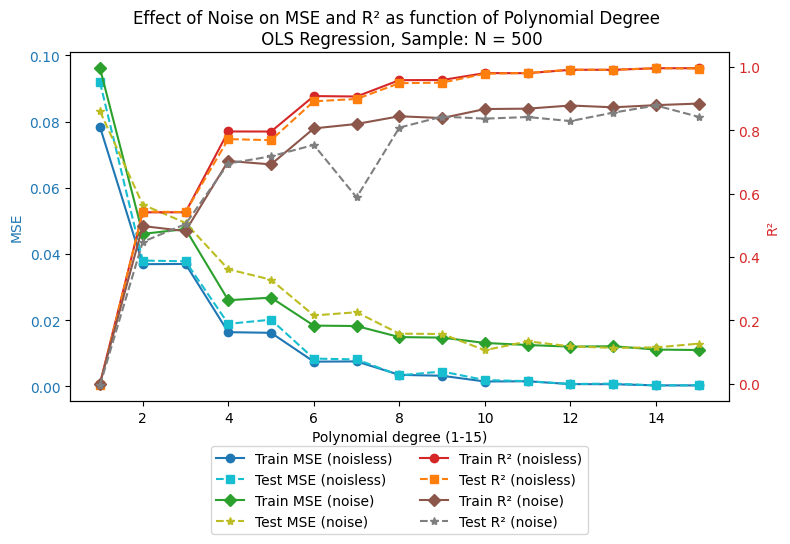

In [180]:
fig, ax1 = plt.subplots(figsize=(8, 6))

# left y-side: MSE
ax1.plot(degree_vec, MSE_train, 'o-', label='Train MSE (noisless)', color='tab:blue')
ax1.plot(degree_vec, MSE_test, 's--', label='Test MSE (noisless)', color='tab:cyan')
ax1.plot(degree_vec, MSE_train_withnoise, 'D-', label='Train MSE (noise)', color='tab:green')
ax1.plot(degree_vec, MSE_test_withnoise, '*--', label='Test MSE (noise)', color='tab:olive')
ax1.set_xlabel(f'Polynomial degree (1-{degree_vec[-1]})')
ax1.set_ylabel('MSE', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')
# ax1.set_yscale('log')
# right y-side: R²
ax2 = ax1.twinx()
ax2.plot(degree_vec, Rsquared_train, 'o-', label='Train R² (noisless)', color='tab:red')
ax2.plot(degree_vec, Rsquared_test, 's--', label='Test R² (noisless)', color='tab:orange')
ax2.plot(degree_vec, Rsquared_train_withnoise, 'D-', label='Train R² (noise)', color='tab:brown')
ax2.plot(degree_vec, Rsquared_test_withnoise, '*--', label='Test R² (noise)', color='tab:gray')
ax2.set_ylabel('R²', color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')
# ax2.set_yscale('log')
# combine legends from both axes
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2,
           loc='lower center', bbox_to_anchor=(0.5, -0.4), ncol=2)

plt.title(f'Effect of Noise on MSE and R² as function of Polynomial Degree \n OLS Regression, Sample: N = {N}')
plt.tight_layout()
plt.savefig(rf"{figpath}\ols_analysis_N{N}.png")
plt.show()

Comments to A:
we dont plot theta(max order) as the choiseof coefficience is much more up to chance, unlike in ridge where their penalty will depend on higher orders they are put up against. Hence we rather demonstrate the fluctuation not as function of polynomial order but wherther we include the noise or not and what the sample size is. We study fist and last order too see that the fluctuations are greater if sample size is chosen small. A clear visual parallell can be seen in the overall MSE. In the graph the more the blue and green or orange and brown graphs diverge the more untable is the final solution. 
The reason is that the stochastic term N(0,1) for large sample becomes averaged 0 effect, (Law of big numbers) but for small samples it has no sturucture and influence the modeling process quite significantly, perturb the runge function to something wihich no longer is the runge function. 

- Runge n->inf ocillation divergence non uniform at interval
- non equidictant cample pointc chebychev pointc
- pinv: cvd decompiciton

### part B

### Explore MSE(Lambda, P, Noise)

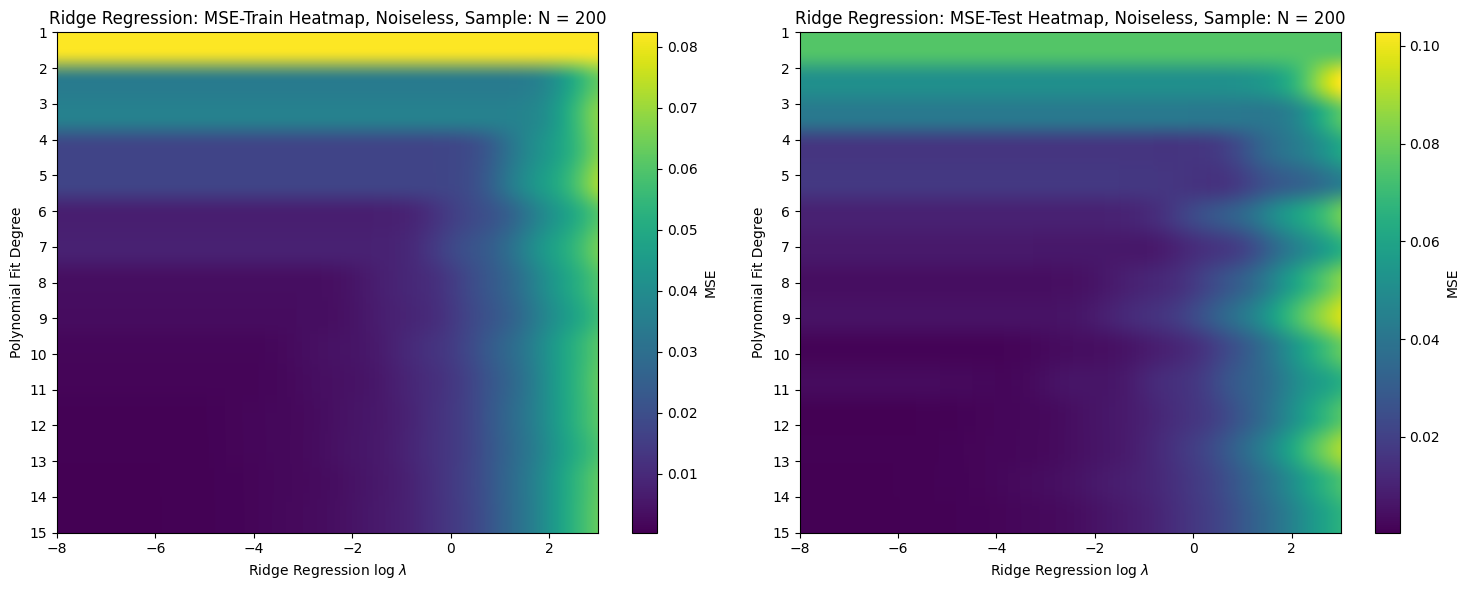

In [181]:
N = 200
degree_vec = np.arange(1, P+1)
lambda_vec = np.logspace(-8, 3, 500)  

MSE_train_heatmap = np.zeros((len(degree_vec), len(lambda_vec)))
MSE_test_heatmap = np.zeros((len(degree_vec), len(lambda_vec)))

x, y = runge_function(N, noise=False)

for i, degree in enumerate(degree_vec):  
    X_train_scaled, X_test_scaled, pip, pip, y_sc, y_offset, y_test, max_eig = pre_processing(x, y, N, degree)
    for j, l_val in enumerate(lambda_vec):
        theta_ridge, mse_train_ridge, mse_test_ridge, bip, bop = ridge_analysis(X_train_scaled, X_test_scaled, y_sc, y_offset, y_test, l_val)
        MSE_train_heatmap[i, j] = mse_train_ridge
        MSE_test_heatmap[i, j] = mse_test_ridge

# Create heatmaps
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Train-MSE heatmap
im1 = ax1.imshow(MSE_train_heatmap, aspect='auto', cmap='viridis', extent=[np.log10(lambda_vec[0]), np.log10(lambda_vec[-1]), degree_vec[-1], degree_vec[0]])
ax1.set_xlabel('Ridge Regression log $\lambda$')
ax1.set_ylabel('Polynomial Fit Degree')
ax1.set_title(f'Ridge Regression: MSE-Train Heatmap, Noiseless, Sample: N = {N}')
ax1.set_yticks(degree_vec)
fig.colorbar(im1, ax=ax1, label='MSE')

# Test-MSE heatmap
im2 = ax2.imshow(MSE_test_heatmap, aspect='auto', cmap='viridis',extent=[np.log10(lambda_vec[0]), np.log10(lambda_vec[-1]), degree_vec[-1], degree_vec[0]])
ax2.set_xlabel('Ridge Regression log $\lambda$')
ax2.set_ylabel('Polynomial Fit Degree')
ax2.set_title(f'Ridge Regression: MSE-Test Heatmap, Noiseless, Sample: N = {N}')
ax2.set_yticks(degree_vec)
fig.colorbar(im2, ax=ax2, label='MSE')

plt.tight_layout()
plt.savefig(rf"{figpath}\ridge_heatmap_noiseless.png")
plt.show()

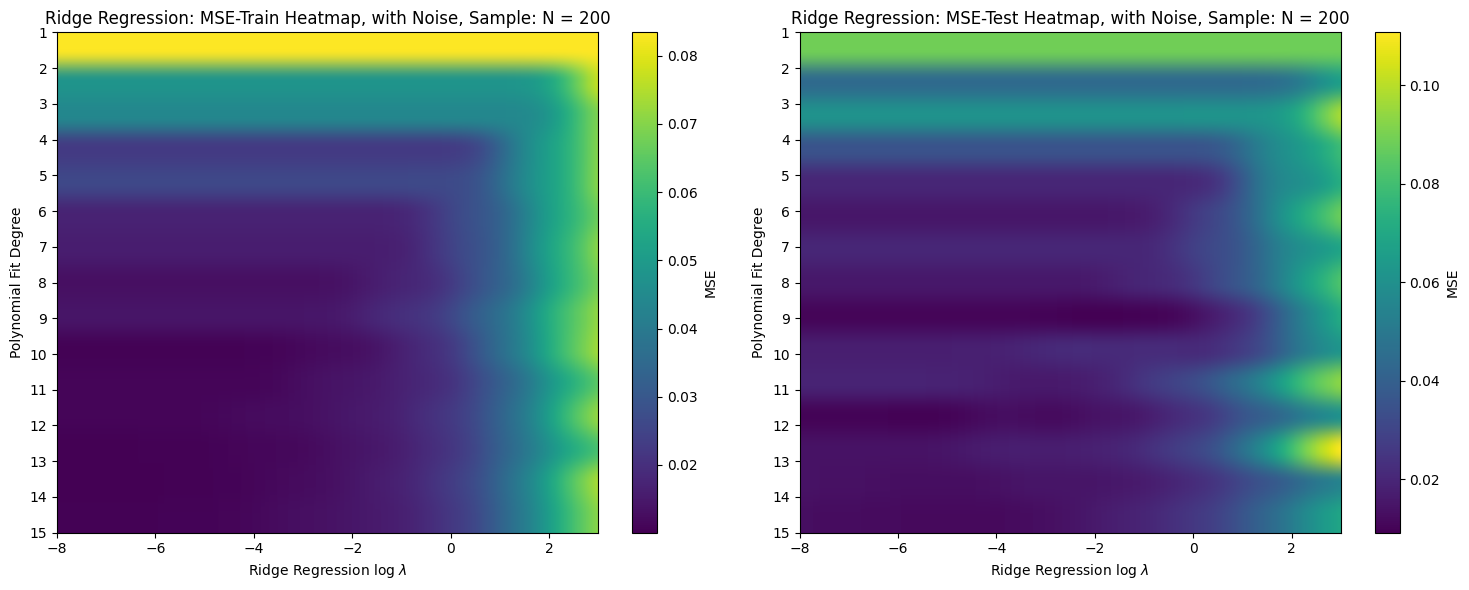

In [182]:
N = 200
degree_vec = np.arange(1, P+1)
lambda_vec = np.logspace(-8, 3, 500)  

MSE_train_heatmap = np.zeros((len(degree_vec), len(lambda_vec)))
MSE_test_heatmap = np.zeros((len(degree_vec), len(lambda_vec)))

x, y = runge_function(N, noise=True)

for i, degree in enumerate(degree_vec):  
    X_train_scaled, X_test_scaled, pip, pip, y_sc, y_offset, y_test, max_eig = pre_processing(x, y, N, degree)
    for j, l_val in enumerate(lambda_vec):
        theta_ridge, mse_train_ridge, mse_test_ridge, bip, bop = ridge_analysis(X_train_scaled, X_test_scaled, y_sc, y_offset, y_test, l_val)
        MSE_train_heatmap[i, j] = mse_train_ridge
        MSE_test_heatmap[i, j] = mse_test_ridge

# Create heatmaps
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Train-MSE heatmap
im1 = ax1.imshow(MSE_train_heatmap, aspect='auto', cmap='viridis', extent=[np.log10(lambda_vec[0]), np.log10(lambda_vec[-1]), degree_vec[-1], degree_vec[0]])
ax1.set_xlabel('Ridge Regression log $\lambda$')
ax1.set_ylabel('Polynomial Fit Degree')
ax1.set_title(f'Ridge Regression: MSE-Train Heatmap, with Noise, Sample: N = {N}')
ax1.set_yticks(degree_vec)
fig.colorbar(im1, ax=ax1, label='MSE')

# Test-MSE heatmap
im2 = ax2.imshow(MSE_test_heatmap, aspect='auto', cmap='viridis',extent=[np.log10(lambda_vec[0]), np.log10(lambda_vec[-1]), degree_vec[-1], degree_vec[0]])
ax2.set_xlabel('Ridge Regression log $\lambda$')
ax2.set_ylabel('Polynomial Fit Degree')
ax2.set_title(f'Ridge Regression: MSE-Test Heatmap, with Noise, Sample: N = {N}')
ax2.set_yticks(degree_vec)
fig.colorbar(im2, ax=ax2, label='MSE')

plt.tight_layout()
plt.savefig(rf"{figpath}\ridge_heatmap_withnoise.png")
plt.show()

### Compare MSE Stability for OLS vs Ridge High order fit of Runge Function without noise

In [183]:
N = 500
P = 80
degree_vec = np.arange(1, P+1)
lambda_vec = np.array([1e-8, 1e-3])

ols_MSE_train = []
ols_MSE_test = []

ols_MSE_train_withnoise = []
ols_MSE_test_withnoise = []
ridge_MSE_train_withnoise = []
ridge_MSE_test_withnoise = []

ridge2_MSE_train_withnoise = []
ridge2_MSE_test_withnoise = []

# Noiseless
x, y = runge_function(N, noise=False)
for degree in degree_vec:
    X_train_scaled, X_test_scaled, pip, pip, y_sc, y_offset, y_test, max_eig = pre_processing(x, y, N, degree)
    theta_ols, mse_train_ols, mse_test_ols, bip, boop = ols_analysis(X_train_scaled, X_test_scaled, y_sc, y_offset, y_test)
    ols_MSE_train.append(mse_train_ols)   
    ols_MSE_test.append(mse_test_ols)

# With Noise
x, y = runge_function(N, noise=False)

for degree in degree_vec:
    X_train_scaled, X_test_scaled, pip, pip, y_sc, y_offset, y_test, max_eig = pre_processing(x, y, N, degree)
    
    theta_ols, mse_train_ols, mse_test_ols, bip, boop = ols_analysis(X_train_scaled, X_test_scaled, y_sc, y_offset, y_test)
    ols_MSE_train_withnoise.append(mse_train_ols)   
    ols_MSE_test_withnoise.append(mse_test_ols)
    
    theta_ridge, mse_train_ridge, mse_test_ridge, bip, bop = ridge_analysis(X_train_scaled, X_test_scaled, y_sc, y_offset, y_test, lambda_vec[0])
    ridge_MSE_train_withnoise.append(mse_train_ridge)
    ridge_MSE_test_withnoise.append(mse_test_ridge)
    
    theta_ridge, mse_train_ridge, mse_test_ridge, bip, bop = ridge_analysis(X_train_scaled, X_test_scaled, y_sc, y_offset, y_test, lambda_vec[1])
    ridge2_MSE_train_withnoise.append(mse_train_ridge)
    ridge2_MSE_test_withnoise.append(mse_test_ridge)     

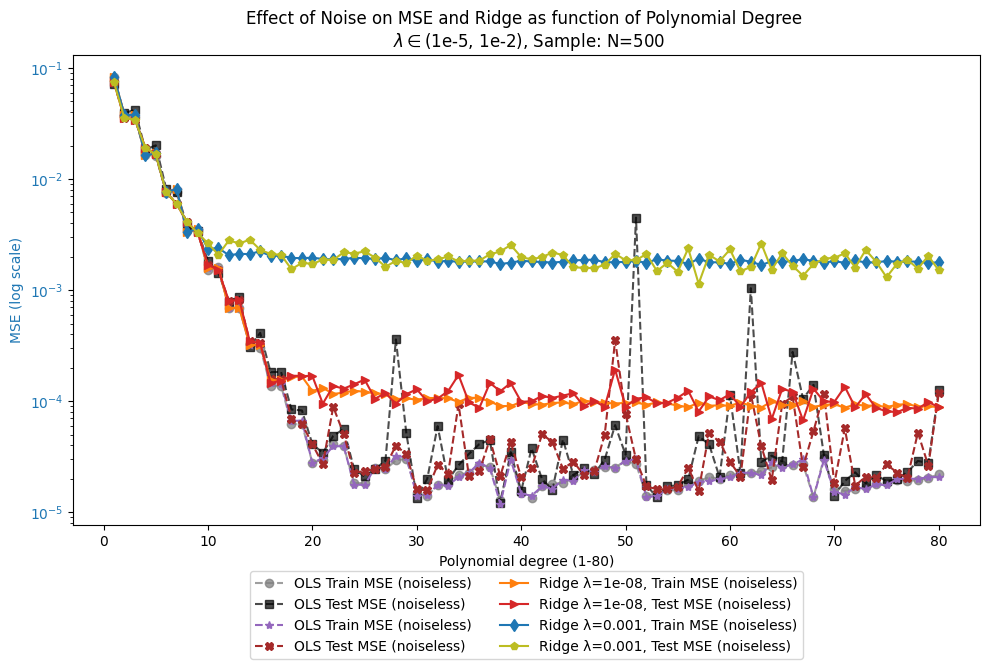

In [184]:
fig, ax = plt.subplots(figsize=(10, 7))

# OLS noiseless (lighter alpha)
ax.plot(degree_vec, ols_MSE_train, 'o--', label='OLS Train MSE (noiseless)', color='tab:grey', alpha=0.75)
ax.plot(degree_vec, ols_MSE_test, 's--', label='OLS Test MSE (noiseless)', color='black', alpha=0.7)

ax.plot(degree_vec, ols_MSE_train_withnoise, '*--', label='OLS Train MSE (noiseless)', color='tab:purple')
ax.plot(degree_vec, ols_MSE_test_withnoise, 'X--', label='OLS Test MSE (noiseless)', color='brown')

# Ridge curves with noise (full alpha)
ax.plot(degree_vec, ridge_MSE_train_withnoise, '>-', label=f'Ridge λ={lambda_vec[0]}, Train MSE (noiseless)', color='tab:orange')
ax.plot(degree_vec, ridge_MSE_test_withnoise, '>-', label=f'Ridge λ={lambda_vec[0]}, Test MSE (noiseless)', color='tab:red')
ax.plot(degree_vec, ridge2_MSE_train_withnoise, 'd-', label=f'Ridge λ={lambda_vec[1]}, Train MSE (noiseless)', color='tab:blue')
ax.plot(degree_vec, ridge2_MSE_test_withnoise, 'p-', label=f'Ridge λ={lambda_vec[1]}, Test MSE (noiseless)', color='tab:olive')

# -----------------------
# Axis labels, log scale, legend, title
# -----------------------
ax.set_xlabel(f'Polynomial degree (1-{degree_vec[-1]})')
ax.set_ylabel('MSE (log scale)', color='tab:blue')
ax.set_yscale('log')
ax.tick_params(axis='y', labelcolor='tab:blue')
# ax.grid(True, which='both', axis='y', linestyle='--', alpha=0.3)

ax.legend(loc='lower center', bbox_to_anchor=(0.5, -0.3), ncol=2)
plt.title(f'Effect of Noise on MSE and Ridge as function of Polynomial Degree \n $\lambda \in$(1e-5, 1e-2), Sample: N={N}')
plt.tight_layout()
plt.savefig(rf"{figpath}\ols_ridge_analysis_N{N}_noiseless.png")
plt.show()

### Compare MSE Stability for OLS vs Ridge High order fit of Runge Function **with** supressed noise $N(0,0.1)/4$

In [185]:
# The Effect is Insane!
# In limiting N>>1, we have on average added 0, but individual values can still with ease outmatch y(x) abs(x)<1, hence we divide by 4
def runge_function(N, noise=True):
    x = np.linspace(-1, 1, N)
    y = 1/(1+25*x**2) 
    if noise:
        y += 0.25*np.random.normal(0, 0.1, size=N) 
    return x, y

In [186]:
N = 500
P = 80
degree_vec = np.arange(1, P+1)
lambda_vec = np.array([1e-8, 1e-3])

ols_MSE_train = []
ols_MSE_test = []

ols_MSE_train_withnoise = []
ols_MSE_test_withnoise = []
ridge_MSE_train_withnoise = []
ridge_MSE_test_withnoise = []

ridge2_MSE_train_withnoise = []
ridge2_MSE_test_withnoise = []

# Noiseless
x, y = runge_function(N, noise=False)
for degree in degree_vec:
    X_train_scaled, X_test_scaled, pip, pip, y_sc, y_offset, y_test, max_eig = pre_processing(x, y, N, degree)
    theta_ols, mse_train_ols, mse_test_ols, bip, boop = ols_analysis(X_train_scaled, X_test_scaled, y_sc, y_offset, y_test)
    ols_MSE_train.append(mse_train_ols)   
    ols_MSE_test.append(mse_test_ols)

# With Noise
x, y = runge_function(N, noise=True)

for degree in degree_vec:
    X_train_scaled, X_test_scaled, pip, pip, y_sc, y_offset, y_test, max_eig = pre_processing(x, y, N, degree)
    
    theta_ols, mse_train_ols, mse_test_ols, bip, boop = ols_analysis(X_train_scaled, X_test_scaled, y_sc, y_offset, y_test)
    ols_MSE_train_withnoise.append(mse_train_ols)   
    ols_MSE_test_withnoise.append(mse_test_ols)
    
    theta_ridge, mse_train_ridge, mse_test_ridge, bip, bop = ridge_analysis(X_train_scaled, X_test_scaled, y_sc, y_offset, y_test, lambda_vec[0])
    ridge_MSE_train_withnoise.append(mse_train_ridge)
    ridge_MSE_test_withnoise.append(mse_test_ridge)
    
    theta_ridge, mse_train_ridge, mse_test_ridge, bip, bop = ridge_analysis(X_train_scaled, X_test_scaled, y_sc, y_offset, y_test, lambda_vec[1])
    ridge2_MSE_train_withnoise.append(mse_train_ridge)
    ridge2_MSE_test_withnoise.append(mse_test_ridge)     

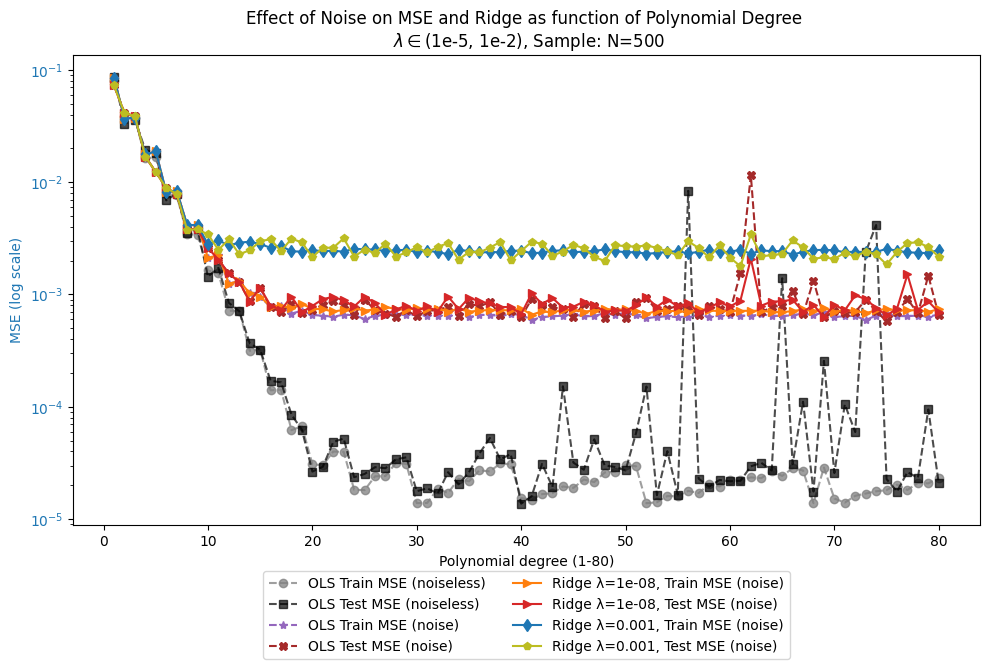

In [187]:
fig, ax = plt.subplots(figsize=(10, 7))

# OLS noiseless (lighter alpha)
ax.plot(degree_vec, ols_MSE_train, 'o--', label='OLS Train MSE (noiseless)', color='tab:grey', alpha=0.75)
ax.plot(degree_vec, ols_MSE_test, 's--', label='OLS Test MSE (noiseless)', color='black', alpha=0.7)

ax.plot(degree_vec, ols_MSE_train_withnoise, '*--', label='OLS Train MSE (noise)', color='tab:purple')
ax.plot(degree_vec, ols_MSE_test_withnoise, 'X--', label='OLS Test MSE (noise)', color='brown')

# Ridge curves with noise (full alpha)
ax.plot(degree_vec, ridge_MSE_train_withnoise, '>-', label=f'Ridge λ={lambda_vec[0]}, Train MSE (noise)', color='tab:orange')
ax.plot(degree_vec, ridge_MSE_test_withnoise, '>-', label=f'Ridge λ={lambda_vec[0]}, Test MSE (noise)', color='tab:red')
ax.plot(degree_vec, ridge2_MSE_train_withnoise, 'd-', label=f'Ridge λ={lambda_vec[1]}, Train MSE (noise)', color='tab:blue')
ax.plot(degree_vec, ridge2_MSE_test_withnoise, 'p-', label=f'Ridge λ={lambda_vec[1]}, Test MSE (noise)', color='tab:olive')

# -----------------------
# Axis labels, log scale, legend, title
# -----------------------
ax.set_xlabel(f'Polynomial degree (1-{degree_vec[-1]})')
ax.set_ylabel('MSE (log scale)', color='tab:blue')
ax.set_yscale('log')
ax.tick_params(axis='y', labelcolor='tab:blue')
# ax.grid(True, which='both', axis='y', linestyle='--', alpha=0.3)

ax.legend(loc='lower center', bbox_to_anchor=(0.5, -0.3), ncol=2)
plt.title(f'Effect of Noise on MSE and Ridge as function of Polynomial Degree \n $\lambda \in$(1e-5, 1e-2), Sample: N={N}')
plt.tight_layout()
plt.savefig(rf"{figpath}\ols_ridge_analysis_withnoise_N{N}.png")
plt.show()

Conclusion: Ridge is more confortable with small N, while OLS instantly collapses.

This is especially relevant in case of higher orders, where OLS looses stabilty to Ridge.

Runge Phenomenon: Fit does not converge at higher orders 

Turning on even damped noise, cripples both almost equally. 

### part C

In [188]:
def get_grad_OLS(theta, FM, y, n):
    return (2.0/n) * FM.T @ (FM @ theta - y)

def get_grad_Ridge(theta, FM, y, lam, n):
    return get_grad_OLS(theta, FM, y, n) + 2*lam*theta/n

In [189]:
def simple_gradient_descend(X_train_scaled, X_test_scaled, y_sc, y_offset, y_test, max_eig, eta_vec, mode, l_val):
    eta_vec_scaled = eta_vec / max_eig
    max_iter = 1000
    threshold = 1e-6
    N, degree = X_train_scaled.shape
    theta0 = 2.5*np.ones(degree) 
    log_Ridge = []

    for eta in eta_vec_scaled:
        theta_Ridge = theta0.copy() 
        log_eta_Ridge = [theta_Ridge.copy()]
                  
        for iter in range(max_iter):
            if mode=='ols':
                grad_Ridge = get_grad_OLS(theta_Ridge, X_train_scaled, y_sc, N)
            elif mode=='ridge':
                grad_Ridge = get_grad_Ridge(theta_Ridge, X_train_scaled, y_sc, l_val, N)
            if np.linalg.norm(grad_Ridge) < threshold:
                break
            theta_Ridge -= grad_Ridge*eta
            log_eta_Ridge.append(theta_Ridge.copy())
            # print(theta_Ridge)
        log_Ridge.append(np.array(log_eta_Ridge))
    return log_Ridge


def simple_gradient_descend_old(N, degree, eta_vec, mode='ols', lambda_val=None, noise=False):
    x, y = runge_function(N, noise=noise)
    FM = polynomial_features(x, degree, intercept=False)
    
    # X_train, X_test, y_train, y_test = train_test_split(FM, y, test_size=traintestrat)
    # scaler = StandardScaler()
    # scaler.fit(X_train)
    # X_train_scaled = scaler.transform(X_train)
    # X_test_scaled = scaler.transform(X_test)
    # y_offset = np.mean(y_train)
    
    # Standardize features (zero mean, unit variance for each feature)
    FM_mean = FM.mean(axis=0)
    FM_std = FM.std(axis=0)
    FM_std[FM_std == 0] = 1  # safeguard to avoid division by zero for constant features
    FM_sc = (FM - FM_mean) / FM_std
    # Center the target to zero mean (simplify intercept handling)
    y_offset = np.mean(y)
    y_sc = y - y_offset
    H = (2.0/N) *FM_sc.T @ FM_sc
    EigValues = np.linalg.eig(H)[0]
    eta_vec_scaled = eta_vec / np.max(EigValues)
    # print(eta_vec_scaled)
    max_iter = 1000
    threshold = 1e-6
    theta0 = 2.5*np.ones(degree) 
    log_Ridge = []

    for eta in eta_vec_scaled:
        theta_Ridge = theta0.copy() 
        log_eta_Ridge = [theta_Ridge.copy()]
                  
        for iter in range(max_iter):
            if mode=='ols':
                grad_Ridge = get_grad_OLS(theta_Ridge, FM_sc, y_sc, N)
            elif mode=='ridge':
                grad_Ridge = get_grad_Ridge(theta_Ridge, FM_sc, y_sc, lambda_val, N)
            if np.linalg.norm(grad_Ridge) < threshold:
                break
            theta_Ridge -= grad_Ridge*eta
            log_eta_Ridge.append(theta_Ridge.copy())
            # print(theta_Ridge)
        log_Ridge.append(np.array(log_eta_Ridge))
    return log_Ridge

### Test Fit

In [190]:
def runge_function(N, noise=True):
    x = np.linspace(-1, 1, N)
    y = 1/(1+25*x**2) 
    if noise:
        y += np.random.normal(0, 0.2, size=N) 
    return x, y

In [191]:
N = 500
P = 15
eta_vec = np.array([1.5, 1.99])
l_val = 1e-5

x, y = runge_function(N, noise=True)

X_train_scaled, X_test_scaled, x_train, x_test, y_sc, y_offset, y_test, max_eig = pre_processing(x, y, N, P)

theta_ols = ols_analysis(X_train_scaled, X_test_scaled, y_sc, y_offset, y_test)[0]
theta_ridge = ridge_analysis(X_train_scaled, X_test_scaled, y_sc, y_offset, y_test, l_val)[0]
log_OLS = simple_gradient_descend(X_train_scaled, X_test_scaled, y_sc, y_offset, y_test, max_eig, eta_vec, 'ols', l_val)
log_Ridge = simple_gradient_descend(X_train_scaled, X_test_scaled, y_sc, y_offset, y_test, max_eig, eta_vec, 'ridge', l_val)

# Check Convergence!
print(len(log_OLS[0]))
print(len(log_Ridge[0]))
print(len(log_OLS[1]))
print(len(log_Ridge[1]))

1001
1001
1001
1001


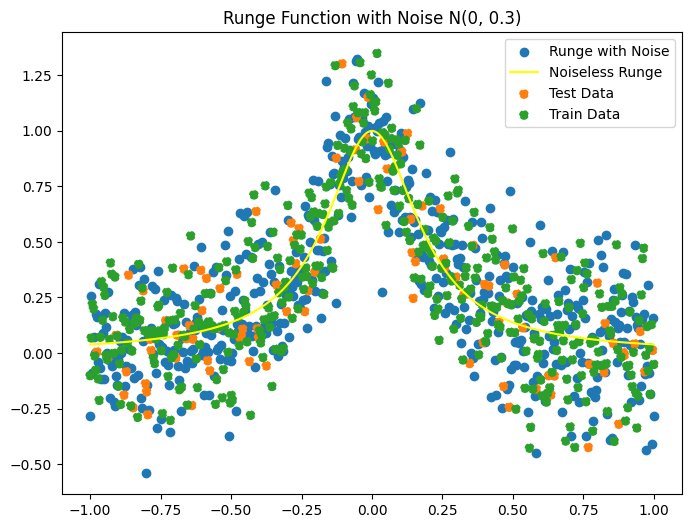

In [192]:
fig, ax = plt.subplots(figsize=(8, 6))
plot_xaxis, plot_yaxis = runge_function(500, True)
plot_xaxis2, plot_yaxis2 = runge_function(500, False)
plt.scatter(plot_xaxis, plot_yaxis, label='Runge with Noise')
plt.plot(plot_xaxis2, plot_yaxis2, label='Noiseless Runge', color='yellow')
plt.scatter(x_test, y_test, ls='--', label='Test Data')
plt.scatter(x_train, y_sc + y_offset, ls='--', label='Train Data')
plt.title("Runge Function with Noise N(0, 0.3)")
plt.legend()
plt.savefig(rf"{figpath}\runge_data.png")
plt.show()

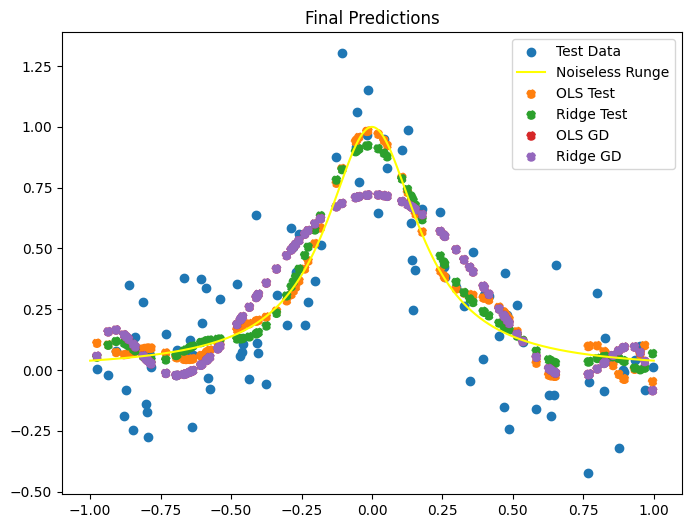

In [193]:
# Plot 2: Final predictions comparison
fig, ax = plt.subplots(figsize=(8, 6))
plt.scatter(x_test, y_test, label='Test Data')
plt.plot(plot_xaxis2, plot_yaxis2, label='Noiseless Runge', color='yellow')
plt.scatter(x_test, X_test_scaled@theta_ols + y_offset, ls='--', label='OLS Test')
plt.scatter(x_test, X_test_scaled@theta_ridge + y_offset, ls='--', label='Ridge Test')
plt.scatter(x_test, X_test_scaled@log_OLS[0][-1] + y_offset, ls='--', label='OLS GD')
plt.scatter(x_test, X_test_scaled@log_Ridge[0][-1] + y_offset, ls='--', label='Ridge GD')
plt.title('Final Predictions')
plt.savefig(rf"{figpath}\ols_ridge_GD_predictions.png")
plt.legend()

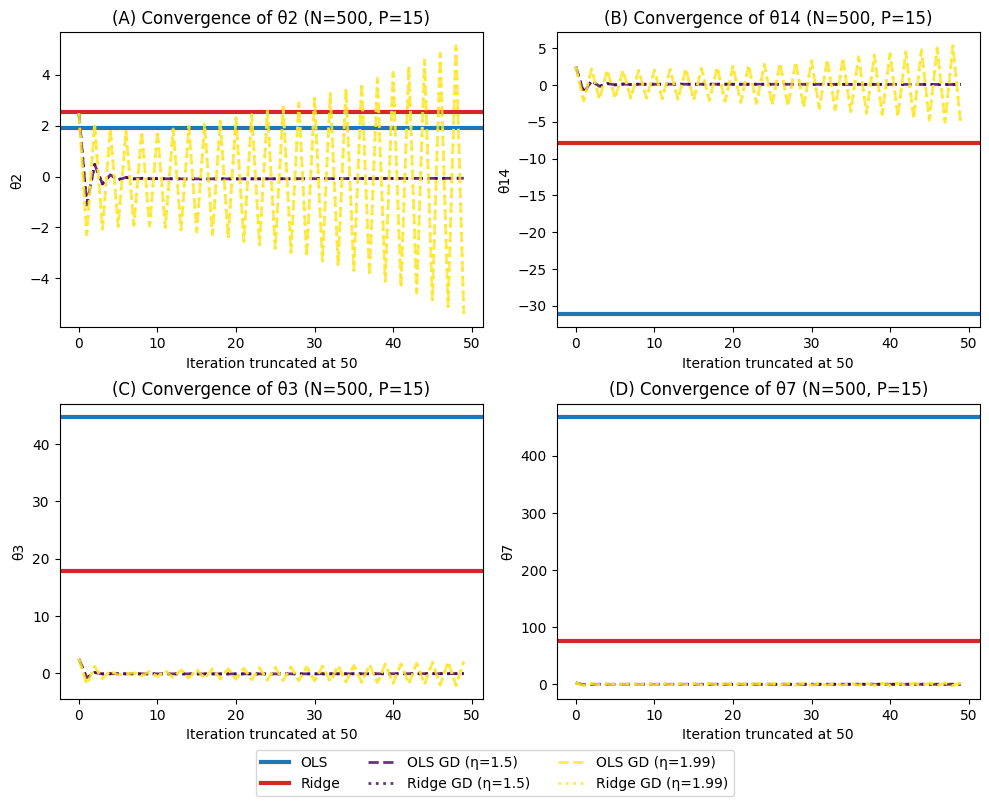

In [194]:
# Pick 6 theta indices you want to show
theta_indices = [2, 14, 3, 7]  #1, 3, 6, 7. 14
max_range = 50

# Make a 2x3 grid (rows=2, cols=3)
fig, axes = plt.subplots(2, 2, figsize=(10, 8), sharey=False)
axes = axes.flatten()

# Letters for subplot labeling
panel_labels = list(string.ascii_uppercase)  # ['A', 'B', 'C', 'D', 'E', 'F', ...]

# Consistent color mapping for eta values
eta_colors = plt.cm.viridis(np.linspace(0, 1, len(eta_vec)))

all_lines = []
all_labels = set()

for ax_idx, (ax, theta_idx) in enumerate(zip(axes, theta_indices)):
    # Non-gradient solutions - only add to legend once
    if ax_idx == 0:
        l1 = ax.axhline(theta_ols[theta_idx], color="tab:blue", linestyle="-", linewidth=3, label="OLS")
        l2 = ax.axhline(theta_ridge[theta_idx], color="tab:red", linestyle="-", linewidth=3, label="Ridge")
        if l1.get_label() not in all_labels:
            all_lines.append(l1); all_labels.add(l1.get_label())
        if l2.get_label() not in all_labels:
            all_lines.append(l2); all_labels.add(l2.get_label())
    else:
        ax.axhline(theta_ols[theta_idx], color="tab:blue", linestyle="-", linewidth=3)
        ax.axhline(theta_ridge[theta_idx], color="tab:red", linestyle="-", linewidth=3)

    # Gradient descent logs for each eta
    for eta_idx, eta_val in enumerate(eta_vec):
        # OLS GD
        n_steps = min(max_range, log_OLS[eta_idx].shape[0])
        l3, = ax.plot(range(n_steps), log_OLS[eta_idx][:n_steps, theta_idx], '--',
                      color=eta_colors[eta_idx], alpha=0.8, linewidth=2,
                      label=f"OLS GD (η={eta_val})" if ax_idx == 0 else "")

        # Ridge GD
        n_steps = min(max_range, log_Ridge[eta_idx].shape[0])
        l4, = ax.plot(range(n_steps), log_Ridge[eta_idx][:n_steps, theta_idx], ':',
                      color=eta_colors[eta_idx], alpha=0.8, linewidth=2,
                      label=f"Ridge GD (η={eta_val})" if ax_idx == 0 else "")

        if ax_idx == 0:
            if l3.get_label() not in all_labels and l3.get_label() != "":
                all_lines.append(l3); all_labels.add(l3.get_label())
            if l4.get_label() not in all_labels and l4.get_label() != "":
                all_lines.append(l4); all_labels.add(l4.get_label())

    # Label axes and titles
    ax.set_xlabel(f"Iteration truncated at {max_range}")
    ax.set_ylabel(f"θ{theta_idx}")
    ax.set_title(f"({panel_labels[ax_idx]}) Convergence of θ{theta_idx} (N={N}, P={P})")

# Single legend for all subplots
fig.legend(handles=all_lines, loc='lower center', bbox_to_anchor=(0.5, -0.01), ncol=3)
plt.tight_layout()
plt.subplots_adjust(bottom=0.12)  # Make room for the legend
plt.savefig(rf"{figpath}\simpleGD_coeffs.png")
plt.show()

From the graph we see that coefficients come from method simplicity and not preprocessing as demonstrated earlier. The Ridge penalty term constrains coefficients while OLS does not. Hence you see though ridge terms have some coeffs in double digits this is independant of the order. While for OLS they magnitude is allowed to grow disproportionately out of bounds. Random coefficients means our model will behave in-homogeneoulsy at different sections of the interval! On the other side our gradient descend tends towards lowest value (0) without fail!

I noticed that when Noise is turned off some of the parameters diverge (and grow away!) when learning rate is around 2

### Code for part D, E, F

In [195]:

# Without Epoch based iteration (only batch mode)
class yagdi_old(BaseEstimator, RegressorMixin):
    def __init__(self, learning_rate=0.01, max_iter=1000, tol=1e-6, optimizer='vanillagd', mode='ols', lambda_val=0.0, momentum=0.9, beta1=0.9, beta2=0.999, epsilon=1e-8, batch_type='batch', batch_size=32, track_coef_history=True):
        """
        Yet Another Gradient Descent Index (YAGDI)
        
        Parameters:
        -----------
        optimizer: 'vanillagd', 'momentum', 'adagrad', 'rmsprop', 'adam'
        mode: 'ols', 'ridge', 'lasso'
        batch_type: 'batch', 'stochastic', 'minibatch'
        """
        self.learning_rate = learning_rate
        self.max_iter = max_iter
        self.tol = tol
        self.optimizer = optimizer
        self.mode = mode
        self.lambda_val = lambda_val
        self.momentum = momentum  # For momentum optimizer
        self.beta1 = beta1        # For Adam/RMSprop first moment
        self.beta2 = beta2        # For Adam second moment
        self.epsilon = epsilon
        self.batch_type = batch_type
        self.batch_size = batch_size
        self.track_coef_history = track_coef_history
        self.coef_history_ = [] 
    
    #=========================================================================
    #=========================================================================
    
    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.coef_ = np.ones(n_features)*2     # hardcoded 2 here <--------!!!
        self.intercept_ = 0.0
        self.loss_history_ = []
        if self.track_coef_history:
            self.coef_history_ = [self.coef_.copy()]
            
        # Initialize optimizer variables
        self._initialize_optimizer_variables(n_features)
       
        for i in range(self.max_iter):
            # Select batch based on batch_type
            X_batch, y_batch = self._get_batch(X, y, i)
            
            # Compute gradient (BATCH gradient with/without regularization and with/without updating learning rate)
            gradient = self._compute_gradient(X_batch, y_batch)
            
            # Store loss 
            current_loss = self._compute_loss(X, y)
            self.loss_history_.append(current_loss)
            
            # Check Convergence
            if np.linalg.norm(gradient) < self.tol:
                break
                
            # Apply optimizer update
            self._apply_optimizer_update(gradient, i)
            
            # Store coefficient history if requested
            if self.track_coef_history:
                self.coef_history_.append(self.coef_.copy())
        
        return self
    
    #=========================================================================
    #=========================================================================

    def _initialize_optimizer_variables(self, n_features):
        """Initialize variables for different optimizers"""
        if self.optimizer == 'momentum':
            self.previous_update = np.zeros(n_features) # setup memtory
        elif self.optimizer == 'adagrad':
            self.G = np.zeros(n_features)  # Cumulative sum of square garadiets
        elif self.optimizer == 'rmsprop':
            self.G2 = np.zeros(n_features) # Running average of suqare gradients
        elif self.optimizer == 'adam':
            self.G3 = np.zeros(n_features) # First moment vector (m)
            self.G4 = np.zeros(n_features) # second moment vector (v)
            self.t = 0 # time step
    
    def _get_batch(self, X, y, iteration):
        """Get appropriate batch based on batch_type"""
        n_samples = X.shape[0]
        
        if self.batch_type == 'batch':
            # Full dataset
            return X, y
            
        elif self.batch_type == 'stochastic':
            # Single random sample
            idx = np.random.randint(n_samples)
            return X[idx:idx+1], y[idx:idx+1]
            
        elif self.batch_type == 'minibatch':
            # Random mini-batch
            batch_size = min(self.batch_size, n_samples)
            indices = np.random.choice(n_samples, batch_size, replace=False)
            return X[indices], y[indices]
    
    #======================================================================================================
    # Gradients
    #======================================================================================================
    
    def _compute_gradient(self, X, y):
        """Compute gradient with regularization"""
        n_samples = X.shape[0]
        residuals = X @ self.coef_ - y
        
        # OLS gradient
        ols_gradient = (2 / n_samples) * X.T @ residuals
        
        # Add regularization
        if self.mode == 'ridge' and self.lambda_val > 0:
            ridge_gradient = (2.0/n_samples)*self.lambda_val*self.coef_
            return ols_gradient + ridge_gradient
            
        elif self.mode == 'lasso' and self.lambda_val > 0:
            # L1 gradient: lambda * sign(theta)
            lasso_gradient = (2.0/n_samples)*self.lambda_val*np.sign(self.coef_)
            # Handle theta=0 
            lasso_gradient[self.coef_ == 0] = 0       # =self.lambda_val * np.random.choice([-1, 1], size=np.sum(self.coef_ == 0))
            return ols_gradient + lasso_gradient
        
        return ols_gradient
    
    def _compute_loss(self, X, y):
        """Compute current loss for monitoring"""
        n_samples = X.shape[0]
        residuals = X @ self.coef_ - y
        mse_loss = np.mean(residuals**2)
        
        if self.mode == 'ridge' and self.lambda_val > 0:
            return mse_loss + self.lambda_val * np.sum(self.coef_**2)   #L2 of theta times lambda (regularization)
        elif self.mode == 'lasso' and self.lambda_val > 0:
            return mse_loss + self.lambda_val * np.sum(np.abs(self.coef_)) 
        
        return mse_loss
    
    #======================================================================================================
    # Learning Rate Modifications
    #======================================================================================================
    
    def _apply_optimizer_update(self, gradient, iteration):
        """Apply optimizer-specific update rule"""
        if self.optimizer == 'vanillagd':
            # Vanilla gradient descent
            self.coef_ -= self.learning_rate * gradient
            
        elif self.optimizer == 'momentum':
            # current update = -learning rate*gradient + momentum parameter*previous update
            current_update = self.learning_rate*gradient + self.momentum*self.previous_update
            self.coef_ -= current_update
            self.previous_update = current_update
            
        elif self.optimizer == 'adagrad':
            # update G with new gradient squared (cumulative gradient)
            # udate theta with - learning rate * new gradient / sqrt(new G val + epsilon const)
            self.G += gradient**2
            adjusted_lr = self.learning_rate / (np.sqrt(self.G) + self.epsilon)
            self.coef_ -= adjusted_lr*gradient
            
        elif self.optimizer == 'rmsprop':
            # update G2 not simply += grad**2but a running averadge: beta*G2+(1-beta)*grad**2
            self.G2 = self.beta1*self.G2 + (1 - self.beta1)*gradient**2
            adjusted_lr2 = self.learning_rate / (np.sqrt(self.G2) + self.epsilon)
            self.coef_ -= adjusted_lr2*gradient 
            
        elif self.optimizer == 'adam':
            # update G3 and G4 like in rmsprop using beta1 and beta2, but G4 has gradient**2
            self.t += 1
            self.G3 = self.beta1 * self.G3 + (1 - self.beta1) * gradient
            self.G4 = self.beta2 * self.G4 + (1 - self.beta2) * gradient**2
            
            # Bias correction (use t*beta as beta_t)
            G3_hat = self.G3 / (1 - self.beta1**self.t)
            G4_hat = self.G4 / (1 - self.beta2**self.t)
            
            self.coef_ -= self.learning_rate * G3_hat / (np.sqrt(G4_hat) + self.epsilon)
    
    def predict(self, X, y_offset):
        return X @ self.coef_ + y_offset

# Yet Another Gradient Descent Index
class yagdi(BaseEstimator, RegressorMixin):
    def __init__(self, learning_rate=0.01, max_iter=1e6, tol=1e-6, optimizer='vanillagd', mode='ols', lambda_val=0.0, momentum=0.9, beta1=0.9, beta2=0.999, epsilon=1e-8, batch_type='batch', batch_size=64, max_epoch=50, track_coef_history=True):
        """
        Yet Another Gradient Descent Index (YAGDI)
        
        Parameters:
        -----------
        optimizer: 'vanillagd', 'momentum', 'adagrad', 'rmsprop', 'adam'
        mode: 'ols', 'ridge', 'lasso'
        batch_type: 'batch', 'stochastic', 'minibatch', 'customsample' (imporance sampling)
        """
        self.learning_rate = learning_rate
        self.max_iter = max_iter
        self.tol = tol
        self.optimizer = optimizer
        self.mode = mode
        self.lambda_val = lambda_val
        self.momentum = momentum  # For momentum optimizer
        self.beta1 = beta1        # For Adam/RMSprop first moment
        self.beta2 = beta2        # For Adam second moment
        self.epsilon = epsilon
        self.batch_type = batch_type
        self.batch_size = batch_size
        self.max_epoch = max_epoch
        self.track_coef_history = track_coef_history
        self.coef_history_ = [] 
        self.N_full = 0
    
    #=========================================================================
    #=========================================================================
    
    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.N_full = n_samples
        self.coef_ = np.ones(n_features)*2     # hardcoded 2 here <--------!!!
        self.intercept_ = 0.0
        self.loss_history_ = []
        if self.track_coef_history:
            self.coef_history_ = [self.coef_.copy()]
            
        # Initialize optimizer variables
        self._initialize_optimizer_variables(n_features)
        
        # Setup Epoch
        if self.batch_type == 'batch':
            for i in range(self.max_iter):
                # Its own sub process independant of epoch!
                X_batch, y_batch = self._get_batch(X, y, i)
                gradient = self._compute_gradient(X_batch, y_batch)
                current_loss = self._compute_loss(X, y)
                self.loss_history_.append(current_loss)
                if np.linalg.norm(gradient) < self.tol:
                    break
                self._apply_optimizer_update(gradient, i)
                if self.track_coef_history:
                    self.coef_history_.append(self.coef_.copy())
            return self 
        
        elif self.batch_type == 'stochastic':
            batches_per_epoch = n_samples
            batch_size = 1
        elif self.batch_type == 'minibatch':
            batches_per_epoch = n_samples // self.batch_size
            if n_samples % self.batch_size != 0:
                batches_per_epoch += 1
            batch_size=self.batch_size
        elif self.batch_type == 'customsample':
            batches_per_epoch = n_samples
            batch_size = 1
       
        total_iterations = 0
        converged = False
        
        for epoch in range(self.max_epoch):
            
            if total_iterations >= self.max_iter:
                break
            if converged:
                break
            
            # Shuffle data at the start of each epoch (for stochastic and minibatch) 
            if self.batch_type != 'batch':
                indices = np.random.permutation(n_samples)
                X_shuffled = X[indices]
                y_shuffled = y[indices]
            else:
                X_shuffled = X
                y_shuffled = y
                
            for batch_idx in range(batches_per_epoch):
                # Calculate start/end index for this batch
                start_idx = batch_idx*batch_size
                end_idx = min(start_idx + batch_size, n_samples) # Handle last batch
                
                # Get the batch from the shuffled data
                X_batch = X_shuffled[start_idx:end_idx]
                y_batch = y_shuffled[start_idx:end_idx]

                # Compute gradient (BATCH gradient with/without regularization and with/without updating learning rate)
                gradient = self._compute_gradient(X_batch, y_batch)
                self._apply_optimizer_update(gradient, total_iterations) 
                total_iterations += 1
                
                if self.track_coef_history:
                    self.coef_history_.append(self.coef_.copy())
                
                if total_iterations >= self.max_iter:
                    break
                
            full_gradient = self._compute_gradient(X, y)
            current_loss = self._compute_loss(X, y)
            self.loss_history_.append(current_loss)
            if np.linalg.norm(full_gradient) < self.tol:
                converged = True
                                
        return self
    
    #=========================================================================
    #=========================================================================

    def _initialize_optimizer_variables(self, n_features):
        """Initialize variables for different optimizers"""
        if self.optimizer == 'momentum':
            self.previous_update = np.zeros(n_features) # setup memtory
        elif self.optimizer == 'adagrad':
            self.G = np.zeros(n_features)  # Cumulative sum of square garadiets
        elif self.optimizer == 'rmsprop':
            self.G2 = np.zeros(n_features) # Running average of suqare gradients
        elif self.optimizer == 'adam':
            self.G3 = np.zeros(n_features) # First moment vector (m)
            self.G4 = np.zeros(n_features) # second moment vector (v)
            self.t = 0 # time step
    
    def _get_batch(self, X, y, iteration):
        """Get appropriate batch based on batch_type"""
        n_samples = X.shape[0]
        
        if self.batch_type == 'batch':
            # Full dataset
            return X, y
            
        elif self.batch_type == 'stochastic':
            # Single random sample
            idx = np.random.randint(n_samples)
            return X[idx:idx+1], y[idx:idx+1]
        
        elif self.batch_type == 'customsample':
            # Importance Sampling defined by custom g(x) = tails of normal distribution
            if not hasattr(self, '_custom_probs'):
                # calculate and cache custom probabilities 
                x_values = X[:, 0]
                
                # # Option A. U-shaped distribution
                # x_normalized = 2 * (x_values - np.min(x_values)) / (np.max(x_values) - np.min(x_values)) - 1
                # self._custom_probs = 1 + x_normalized**2 
                # self._custom_probs = self._custom_probs / np.sum(self._custom_probs) #normalize
                
                # Option B Inverted Normal distribution
                # Fit normal distribution to data
                mu, sigma = np.mean(x_values), np.std(x_values)    
                normal_probs = 1/(sigma * np.sqrt(2 * np.pi)) * np.exp(-0.5 * ((x_values - mu)/sigma)**2)
                # Invert to get higher probability for tails
                self._custom_probs = 1 / (normal_probs + 1e-10)  # Avoid division by zero
                self._custom_probs = self._custom_probs / np.sum(self._custom_probs)
            
            idx = np.random.choice(n_samples, p=self._custom_probs)
            return X[idx:idx+1], y[idx:idx+1]
            
        elif self.batch_type == 'minibatch':
            # Random mini-batch
            batch_size = min(self.batch_size, n_samples)
            indices = np.random.choice(n_samples, batch_size, replace=False)
            return X[indices], y[indices]
    
    #======================================================================================================
    # Gradients
    #======================================================================================================
    
    def _compute_gradient(self, X, y):
        """Compute gradient with regularization"""
        # n_samples = self.N_full #full dataset
        n_samples = X.shape[0] #batch size)
        residuals = X @ self.coef_ - y
        
        # OLS gradient
        ols_gradient = (2 / n_samples) * X.T @ residuals
        
        # Add regularization
        if self.mode == 'ridge' and self.lambda_val > 0:
            ridge_gradient = (2.0/n_samples)*self.lambda_val*self.coef_
            return ols_gradient + ridge_gradient
            
        elif self.mode == 'lasso' and self.lambda_val > 0:
            # L1 gradient: lambda * sign(theta)
            lasso_gradient = (2.0/n_samples)*self.lambda_val*np.sign(self.coef_)
            # Handle theta=0 
            lasso_gradient[self.coef_ == 0] = 0       # =self.lambda_val * np.random.choice([-1, 1], size=np.sum(self.coef_ == 0))
            return ols_gradient + lasso_gradient
        
        return ols_gradient
    
    def _compute_loss(self, X, y):
        """Compute current loss for monitoring"""
        n_samples = X.shape[0]
        residuals = X @ self.coef_ - y
        mse_loss = np.mean(residuals**2)
        
        if self.mode == 'ridge' and self.lambda_val > 0:
            return mse_loss + self.lambda_val * np.sum(self.coef_**2)   #L2 of theta times lambda (regularization)
        elif self.mode == 'lasso' and self.lambda_val > 0:
            return mse_loss + self.lambda_val * np.sum(np.abs(self.coef_)) 
        
        return mse_loss
    
    #======================================================================================================
    # Learning Rate Modifications
    #======================================================================================================
    
    def _apply_optimizer_update(self, gradient, iteration):
        """Apply optimizer-specific update rule"""
        if self.optimizer == 'vanillagd':
            # Vanilla gradient descent
            self.coef_ -= self.learning_rate * gradient
            
        elif self.optimizer == 'momentum':
            # current update = -learning rate*gradient + momentum parameter*previous update
            current_update = self.learning_rate*gradient + self.momentum*self.previous_update
            self.coef_ -= current_update
            self.previous_update = current_update
            
        elif self.optimizer == 'adagrad':
            # update G with new gradient squared (cumulative gradient)
            # udate theta with - learning rate * new gradient / sqrt(new G val + epsilon const)
            self.G += gradient**2
            adjusted_lr = self.learning_rate / (np.sqrt(self.G) + self.epsilon)
            self.coef_ -= adjusted_lr*gradient
            
        elif self.optimizer == 'rmsprop':
            # update G2 not simply += grad**2but a running averadge: beta*G2+(1-beta)*grad**2
            self.G2 = self.beta1*self.G2 + (1 - self.beta1)*gradient**2
            adjusted_lr2 = self.learning_rate / (np.sqrt(self.G2) + self.epsilon)
            self.coef_ -= adjusted_lr2*gradient 
            
        elif self.optimizer == 'adam':
            # update G3 and G4 like in rmsprop using beta1 and beta2, but G4 has gradient**2
            self.t += 1
            self.G3 = self.beta1 * self.G3 + (1 - self.beta1) * gradient
            self.G4 = self.beta2 * self.G4 + (1 - self.beta2) * gradient**2
            
            # Bias correction (use t*beta as beta_t)
            G3_hat = self.G3 / (1 - self.beta1**self.t)
            G4_hat = self.G4 / (1 - self.beta2**self.t)
            
            self.coef_ -= self.learning_rate * G3_hat / (np.sqrt(G4_hat) + self.epsilon)
    
    def predict(self, X, y_offset):
        return X @ self.coef_ + y_offset

### part D: compare Vanilla GD, ADAGRAD, RMSProp and ADAM on OLS, and full Batch mode

In [196]:
N = 500
P = 15
np.random.seed(42)

x, y = runge_function(N, noise=True)
#generate the big FM with max degree (in loop we slice it)
X_train_scaled, X_test_scaled, x_train, x_test, y_sc, y_offset, y_test, max_eig = pre_processing(x, y, N, P)

# define test pipleine
optimizers = ['vanillagd', 'adagrad', 'rmsprop', 'adam']
results = {}
loss_log = {}
theta_log = {}
models = {}

for optimizer in optimizers:
    # Initialize Learning Rates
    if optimizer == 'vanillagd':
        lr = 0.01
    elif optimizer == 'adagrad':
        lr = 0.1  # needs higher initial LR due to its cumulative dacay of learning rate
    elif optimizer == 'rmsprop':
        lr = 0.01
    elif optimizer == 'adam':
        lr = 0.01
    
    model = yagdi(
        learning_rate=lr,
        max_iter=1000,
        tol=1e-6,
        optimizer=optimizer,
        mode='ols', # no regularization
        batch_type='batch', # full set
        track_coef_history=True
    )
    
    # Fit model and store coefficient history
    model.fit(X_train_scaled, y_sc)
    models[optimizer] = model
    y_pred = model.predict(X_test_scaled, y_offset)
    mse = mean_squared_error(y_test, y_pred)
    results[optimizer] = mse
    loss_log[optimizer] = model.loss_history_
    theta_log[optimizer] = model.coef_history_

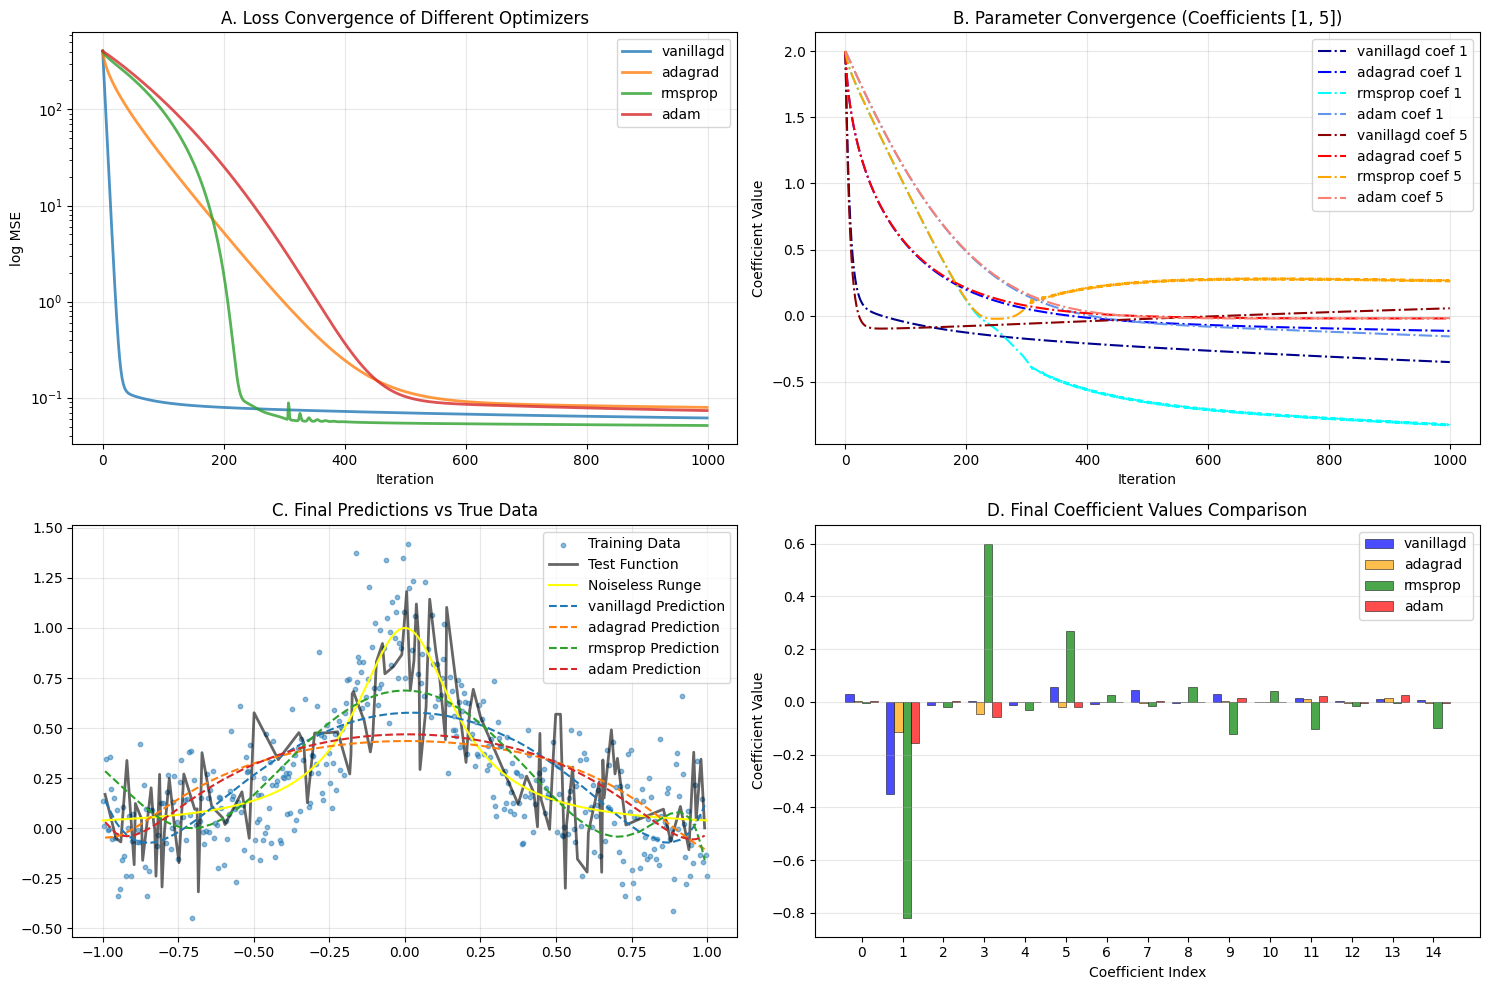

In [197]:
#=================================================================================================
# 1. Plot Loss Convergence
#=================================================================================================

plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
for optimizer, losses in loss_log.items():
    plt.plot(losses, label=optimizer, alpha=0.8, linewidth=2)

plt.xlabel('Iteration')
plt.ylabel('log MSE')
plt.title('A. Loss Convergence of Different Optimizers')
plt.yscale('log')
plt.legend()
plt.grid(True, alpha=0.3)

#=================================================================================================
# 2. Plot Parameter Convergence (specific coefficients)
#=================================================================================================

coefficients_to_plot = [1, 5]  # Specify which coefficients to track (max 2 at once, thank me later)
plt.subplot(2, 2, 2)

# Define color schemes for each coefficient
color_schemes = {
    0: ['darkblue', 'blue', 'cyan', 'cornflowerblue'],  # Blue tones for coefficient 1
    1: ['darkred', 'red', 'orange', 'salmon']           # Red tones for coefficient 2
}

for i, coef_idx in enumerate(coefficients_to_plot):
    for j, (optimizer, coef_history) in enumerate(theta_log.items()):
        if coef_idx < len(coef_history[0]):  # Check if coefficient index exists
            coef_values = [coef[coef_idx] for coef in coef_history]
            color = color_schemes[i][j % len(color_schemes[i])]  # Cycle through colors
            plt.plot(coef_values, label=f'{optimizer} coef {coef_idx}', alpha=1, ls='-.', linewidth=1.5, color=color)

plt.xlabel('Iteration')
plt.ylabel('Coefficient Value')
plt.title(f'B. Parameter Convergence (Coefficients {[x for x in coefficients_to_plot]})')
plt.legend()
plt.grid(True, alpha=0.3)

#=================================================================================================
# 3. Plot Final Predictions vs True Data
#=================================================================================================

plt.subplot(2, 2, 3)
sort_idx = np.argsort(x_test)
x_test_sorted = x_test[sort_idx]
y_test_sorted = y_test[sort_idx]

plt.scatter(x_train, y_sc + y_offset, alpha=0.5, label='Training Data', s=10)
plt.plot(x_test_sorted, y_test_sorted, 'k-', linewidth=2, label='Test Function', alpha=0.6)
plot_xaxis2, plot_yaxis2 = runge_function(N, False)
plt.plot(plot_xaxis2, plot_yaxis2, label='Noiseless Runge', color='yellow')

for optimizer, model in models.items():
    y_pred_test = model.predict(X_test_scaled, y_offset) 
    y_pred_test_sorted = y_pred_test[sort_idx]
    plt.plot(x_test_sorted, y_pred_test_sorted, '--', linewidth=1.5, label=f'{optimizer} Prediction')


plt.title('C. Final Predictions vs True Data')
plt.legend()
plt.grid(True, alpha=0.3)

#=================================================================================================
# 4. Plot Final Coefficients Comparison
#=================================================================================================

plt.subplot(2, 2, 4)

n_coefs = len(models['vanillagd'].coef_)
x_pos = np.arange(n_coefs)
bar_width = 0.2  # Width of each bar

# Create positions for each optimizer's bars
positions = []
for i, optimizer in enumerate(optimizers):
    positions.append(x_pos + i * bar_width)

# Plot bars for each optimizer
colors = ['blue', 'orange', 'green', 'red']
for i, (optimizer, model) in enumerate(models.items()):
    plt.bar(positions[i], model.coef_, width=bar_width, 
            label=optimizer, alpha=0.7, color=colors[i], edgecolor='black', linewidth=0.5)

plt.xlabel('Coefficient Index')
plt.ylabel('Coefficient Value')
plt.title('D. Final Coefficient Values Comparison')
plt.legend()
plt.grid(True, alpha=0.3, axis='y')

# Set x-ticks to be in the middle of each group
plt.xticks(x_pos + bar_width * (len(optimizers) - 1) / 2, x_pos)

plt.tight_layout()
plt.savefig(rf"{figpath}\advanvedGD.png")
plt.show()

### part E: compare RMSProp and ADAM on Ridge and Lasso, still full Batch mode

In [198]:
N = 500
P = 15
np.random.seed(42)

x, y = runge_function(N, noise=True)
X_train_scaled, X_test_scaled, x_train, x_test, y_sc, y_offset, y_test, max_eig = pre_processing(x, y, N, P)

# Define test pipeline: RMSprop and Adam for Ridge and Lasso
optimizers = ['rmsprop', 'adam']
regularizations = ['ridge', 'lasso']
l_val = 1e-3  # Regularization parameter (lambda)

results = {}
loss_log = {}
theta_log = {}
models = {}

for optimizer in optimizers:
    for regularization in regularizations:
        
        lr = 0.01 # Learning Rate common for both
        model = yagdi(
            learning_rate=lr,
            max_iter=1000,
            tol=1e-6,
            optimizer=optimizer,
            mode=regularization,
            lambda_val=l_val,
            batch_type='batch',
            track_coef_history=True
        )
        
        # Fit model and store coefficient history
        model.fit(X_train_scaled, y_sc)
        models[f"{optimizer}_{regularization}"] = model
        
        # Make predictions
        y_pred = model.predict(X_test_scaled, y_offset)
        mse = mean_squared_error(y_test, y_pred)
        
        results[f"{optimizer}_{regularization}"] = mse
        loss_log[f"{optimizer}_{regularization}"] = model.loss_history_
        theta_log[f"{optimizer}_{regularization}"] = model.coef_history_

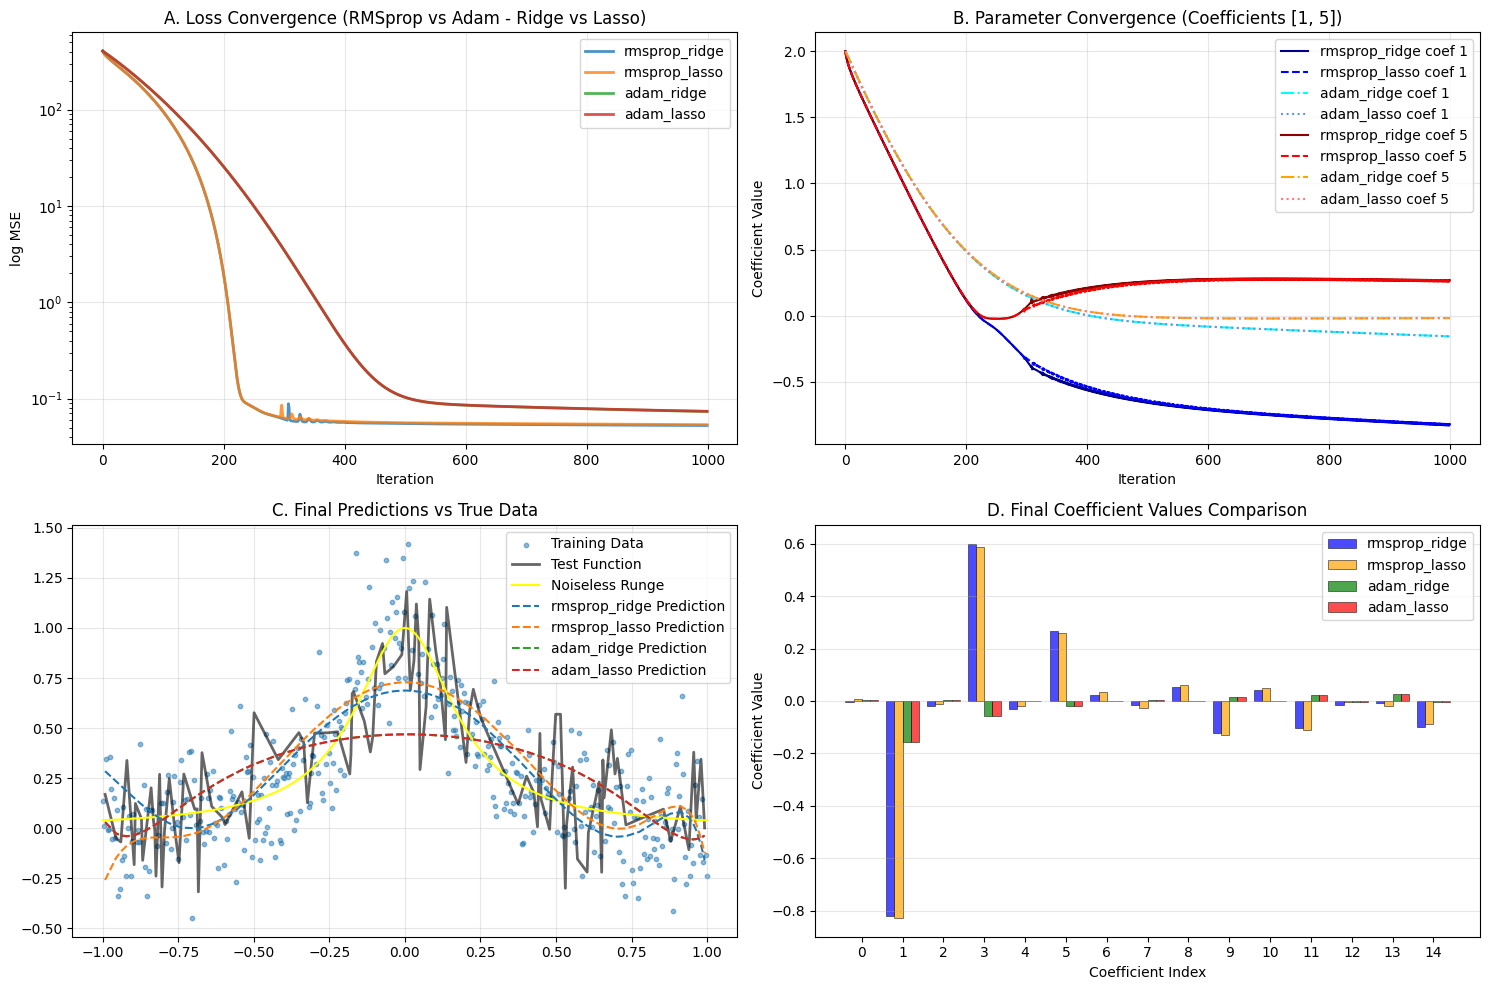

In [199]:
#=================================================================================================
# 1. Plot Loss Convergence
#=================================================================================================

plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
for key, losses in loss_log.items():
    plt.plot(losses, label=key, alpha=0.8, linewidth=2)

plt.xlabel('Iteration')
plt.ylabel('log MSE')
plt.title('A. Loss Convergence (RMSprop vs Adam - Ridge vs Lasso)')
plt.yscale('log')
plt.legend()
plt.grid(True, alpha=0.3)

#=================================================================================================
# 2. Plot Parameter Convergence (specific coefficients)
#=================================================================================================

coefficients_to_plot = [1, 5]  # Specify which coefficients to track
plt.subplot(2, 2, 2)

# Define color schemes for each coefficient
color_schemes = {
    0: ['darkblue', 'blue', 'cyan', 'cornflowerblue'],  # Blue tones for coefficient 1
    1: ['darkred', 'red', 'orange', 'salmon']           # Red tones for coefficient 2
}

line_styles = {'rmsprop_ridge': '-', 'rmsprop_lasso': '--', 
               'adam_ridge': '-.', 'adam_lasso': ':'}

for i, coef_idx in enumerate(coefficients_to_plot):
    for j, (key, coef_history) in enumerate(theta_log.items()):
        if coef_idx < len(coef_history[0]):
            coef_values = [coef[coef_idx] for coef in coef_history]
            color = color_schemes[i][j % len(color_schemes[i])]
            ls = line_styles[key]
            plt.plot(coef_values, label=f'{key} coef {coef_idx}', 
                    alpha=1, ls=ls, linewidth=1.5, color=color)

plt.xlabel('Iteration')
plt.ylabel('Coefficient Value')
plt.title(f'B. Parameter Convergence (Coefficients {[x for x in coefficients_to_plot]})')
plt.legend()
plt.grid(True, alpha=0.3)

#=================================================================================================
# 3. Plot Final Predictions vs True Data
#=================================================================================================

plt.subplot(2, 2, 3)
sort_idx = np.argsort(x_test)
x_test_sorted = x_test[sort_idx]
y_test_sorted = y_test[sort_idx]

plt.scatter(x_train, y_sc + y_offset, alpha=0.5, label='Training Data', s=10)
plt.plot(x_test_sorted, y_test_sorted, 'k-', linewidth=2, label='Test Function', alpha=0.6)
plot_xaxis2, plot_yaxis2 = runge_function(N, False)
plt.plot(plot_xaxis2, plot_yaxis2, label='Noiseless Runge', color='yellow')

for key, model in models.items():
    y_pred_test = model.predict(X_test_scaled, y_offset)
    y_pred_test_sorted = y_pred_test[sort_idx]
    plt.plot(x_test_sorted, y_pred_test_sorted, '--', linewidth=1.5, label=f'{key} Prediction')

plt.title('C. Final Predictions vs True Data')
plt.legend()
plt.grid(True, alpha=0.3)

#=================================================================================================
# 4. Plot Final Coefficients Comparison
#=================================================================================================

plt.subplot(2, 2, 4)

n_coefs = len(models['rmsprop_ridge'].coef_)
x_pos = np.arange(n_coefs)
bar_width = 0.2  # Width of each bar

# Create positions for each method's bars
positions = []
keys = list(models.keys())
for i, key in enumerate(keys):
    positions.append(x_pos + i * bar_width)

# Plot bars for each method
colors = ['blue', 'orange', 'green', 'red']
for i, (key, model) in enumerate(models.items()):
    plt.bar(positions[i], model.coef_, width=bar_width, 
            label=key, alpha=0.7, color=colors[i], edgecolor='black', linewidth=0.5)

plt.xlabel('Coefficient Index')
plt.ylabel('Coefficient Value')
plt.title('D. Final Coefficient Values Comparison')
plt.legend()
plt.grid(True, alpha=0.3, axis='y')

# Set x-ticks to be in the middle of each group
plt.xticks(x_pos + bar_width * (len(keys) - 1) / 2, x_pos)

plt.tight_layout()
plt.savefig(rf"{figpath}\lasso_GD.png")
plt.show()

### part F: SGD/Batch/Minibatch Test with Lasso-RMSprop 

In [200]:
N = 500
P = 15
np.random.seed(42)

x, y = runge_function(N, noise=True)
X_train_scaled, X_test_scaled, x_train, x_test, y_sc, y_offset, y_test, max_eig = pre_processing(x, y, N, P)

# Define test pipeline: RMSprop-Lasso for batch, mini-batch and stochastic
batch_types = ['batch', 'minibatch', 'stochastic', 'customsample']
l_val = 1e-3  # Regularization parameter (lambda)

results = {}
loss_log = {}
theta_log = {}
models = {}

for batch_type in batch_types:
    
    if batch_type == 'batch':
        lr = 0.01
        max_iter = 50000  
        max_epoch = 100   # will be ignored anyway by batch sub-script
    elif batch_type == 'minibatch':
        lr = 0.01
        max_iter = 50000  # Set high to not interfere with epoch limit
        max_epoch = 100
    elif batch_type == 'stochastic':
        lr = 0.001       # Usually needs smaller LR due to noise
        max_iter = 50000  # Set high to not interfere with epoch limit
        max_epoch = 100   # Needs more epochs due to noise
    elif batch_type == 'customsample':
        lr = 0.001       # Usually needs smaller LR due to noise
        max_iter = 50000  # Set high to not interfere with epoch limit
        max_epoch = 100   # Needs more epochs due to noise
    
    model = yagdi(
        learning_rate=lr,
        max_iter=max_iter,
        tol=1e-6,
        optimizer='rmsprop',
        mode='lasso',
        lambda_val=l_val,
        batch_type=batch_type,
        batch_size=16,     # For minibatch    # <====== !
        max_epoch=max_epoch,
        track_coef_history=True
    )
    
    # Fit model and store results
    model.fit(X_train_scaled, y_sc)
    models[batch_type] = model
    
    # Make predictions
    y_pred = model.predict(X_test_scaled, y_offset)
    mse = mean_squared_error(y_test, y_pred)
    
    results[batch_type] = mse
    loss_log[batch_type] = model.loss_history_
    theta_log[batch_type] = model.coef_history_

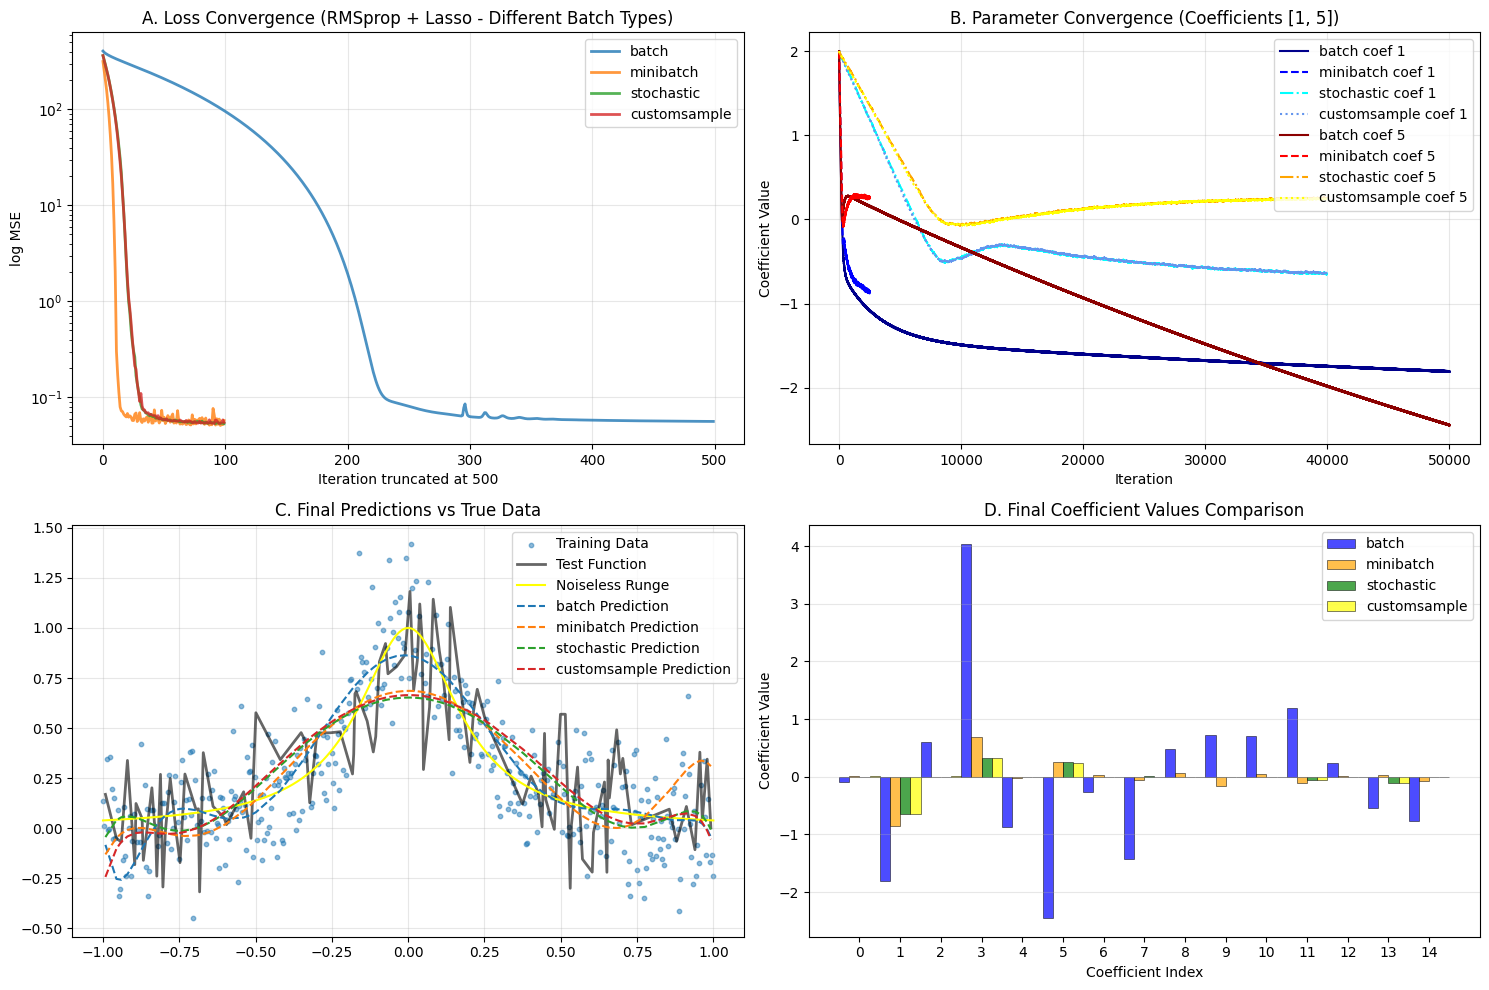

In [201]:
# =================================================================================================
# 1. Plot Loss Convergence
# =================================================================================================

plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
for key, losses in loss_log.items():
    plt.plot(losses[:500], label=key, alpha=0.8, linewidth=2)

plt.xlabel('Iteration truncated at 500')
plt.ylabel('log MSE')
plt.title('A. Loss Convergence (RMSprop + Lasso - Different Batch Types)')
plt.yscale('log')
plt.legend()
plt.grid(True, alpha=0.3)

# =================================================================================================
# 2. Plot Parameter Convergence (specific coefficients)
# =================================================================================================

coefficients_to_plot = [1, 5]  # Specify which coefficients to track
plt.subplot(2, 2, 2)

# Define color schemes for each coefficient
color_schemes = {
    0: ['darkblue', 'blue', 'cyan', 'cornflowerblue'],  # Blue tones for coefficient 1
    1: ['darkred', 'red', 'orange', 'yellow']           # Red tones for coefficient 2
}

line_styles = {'batch': '-', 'minibatch': '--', 'stochastic': '-.', 'customsample': ':'}

for i, coef_idx in enumerate(coefficients_to_plot):
    for j, (key, coef_history) in enumerate(theta_log.items()):
        if coef_idx < len(coef_history[0]):
            coef_values = [coef[coef_idx] for coef in coef_history]
            color = color_schemes[i][j % len(color_schemes[i])]
            ls = line_styles[key]
            plt.plot(coef_values, label=f'{key} coef {coef_idx}', 
                    alpha=1, ls=ls, linewidth=1.5, color=color)

plt.xlabel('Iteration')
plt.ylabel('Coefficient Value')
plt.title(f'B. Parameter Convergence (Coefficients {[x for x in coefficients_to_plot]})')
plt.legend()
plt.grid(True, alpha=0.3)

# =================================================================================================
# 3. Plot Final Predictions vs True Data
# =================================================================================================

plt.subplot(2, 2, 3)
sort_idx = np.argsort(x_test)
x_test_sorted = x_test[sort_idx]
y_test_sorted = y_test[sort_idx]

plt.scatter(x_train, y_sc + y_offset, alpha=0.5, label='Training Data', s=10)
plt.plot(x_test_sorted, y_test_sorted, 'k-', linewidth=2, label='Test Function', alpha=0.6)
plot_xaxis2, plot_yaxis2 = runge_function(N, False)
plt.plot(plot_xaxis2, plot_yaxis2, label='Noiseless Runge', color='yellow')

for key, model in models.items():
    y_pred_test = model.predict(X_test_scaled, y_offset)
    y_pred_test_sorted = y_pred_test[sort_idx]
    plt.plot(x_test_sorted, y_pred_test_sorted, '--', linewidth=1.5, label=f'{key} Prediction')

plt.title('C. Final Predictions vs True Data')
plt.legend()
plt.grid(True, alpha=0.3)

# =================================================================================================
# 4. Plot Final Coefficients Comparison
# =================================================================================================

plt.subplot(2, 2, 4)

n_coefs = len(models['batch'].coef_)
x_pos = np.arange(n_coefs)
bar_width = 0.25  # Width of each bar

# Create positions for each method's bars
positions = []
keys = list(models.keys())
for i, key in enumerate(keys):
    positions.append(x_pos + i * bar_width)

# Plot bars for each method
colors = ['blue', 'orange', 'green', 'yellow']
for i, (key, model) in enumerate(models.items()):
    plt.bar(positions[i], model.coef_, width=bar_width, 
            label=key, alpha=0.7, color=colors[i], edgecolor='black', linewidth=0.5)

plt.xlabel('Coefficient Index')
plt.ylabel('Coefficient Value')
plt.title('D. Final Coefficient Values Comparison')
plt.legend()
plt.grid(True, alpha=0.3, axis='y')

# Set x-ticks to be in the middle of each group
plt.xticks(x_pos + bar_width * (len(keys) - 1) / 2, x_pos)

plt.tight_layout()
plt.savefig(rf"{figpath}\SGD_batches_RMSprop.png")
plt.show()

minibatches with batchsize = 32 converge faster and outperform stochastic
batchsize = 124 converge slower
batchsize = 64 are like stochastic

Sanity chack: batchsize = 1 and the same learning rate as sdg for batshcise =1, and lr=0.001 as in sdg

### Test SDG/MiniBatch and Batch for OLS/Lasso Momentum

In [202]:
N = 500
P = 15
np.random.seed(42)

x, y = runge_function(N, noise=True)
X_train_scaled, X_test_scaled, x_train, x_test, y_sc, y_offset, y_test, max_eig = pre_processing(x, y, N, P)

# Define test pipeline: RMSprop-Lasso for batch, mini-batch and stochastic
batch_types = ['batch', 'minibatch', 'stochastic', 'customsample']

results = {}
loss_log = {}
theta_log = {}
models = {}

for batch_type in batch_types:
    
    if batch_type == 'batch':
        lr = 0.01
        max_iter = 50000  
        max_epoch = 100   # will be ignored anyway by batch sub-script
    elif batch_type == 'minibatch':
        lr = 0.001
        max_iter = 50000  # Set high to not interfere with epoch limit
        max_epoch = 200
    elif batch_type == 'stochastic':
        lr = 0.0001       # Usually needs smaller LR due to noise
        max_iter = 50000  # Set high to not interfere with epoch limit
        max_epoch = 500   # Needs more epochs due to noise
    elif batch_type == 'customsample':
        lr = 0.0001       # Usually needs smaller LR due to noise
        max_iter = 50000  # Set high to not interfere with epoch limit
        max_epoch = 200   # Needs more epochs due to noise
    
    model = yagdi(
        learning_rate=lr,
        max_iter=max_iter,
        tol=1e-6,
        optimizer='momentum',
        mode='lasso',
        lambda_val=1e-3,
        batch_type=batch_type,
        batch_size=32,     # For minibatch
        max_epoch=max_epoch,
        track_coef_history=True
    )
    
    # Fit model and store results
    model.fit(X_train_scaled, y_sc)
    models[batch_type] = model
    
    # Make predictions
    y_pred = model.predict(X_test_scaled, y_offset)
    mse = mean_squared_error(y_test, y_pred)
    
    results[batch_type] = mse
    loss_log[batch_type] = model.loss_history_
    theta_log[batch_type] = model.coef_history_

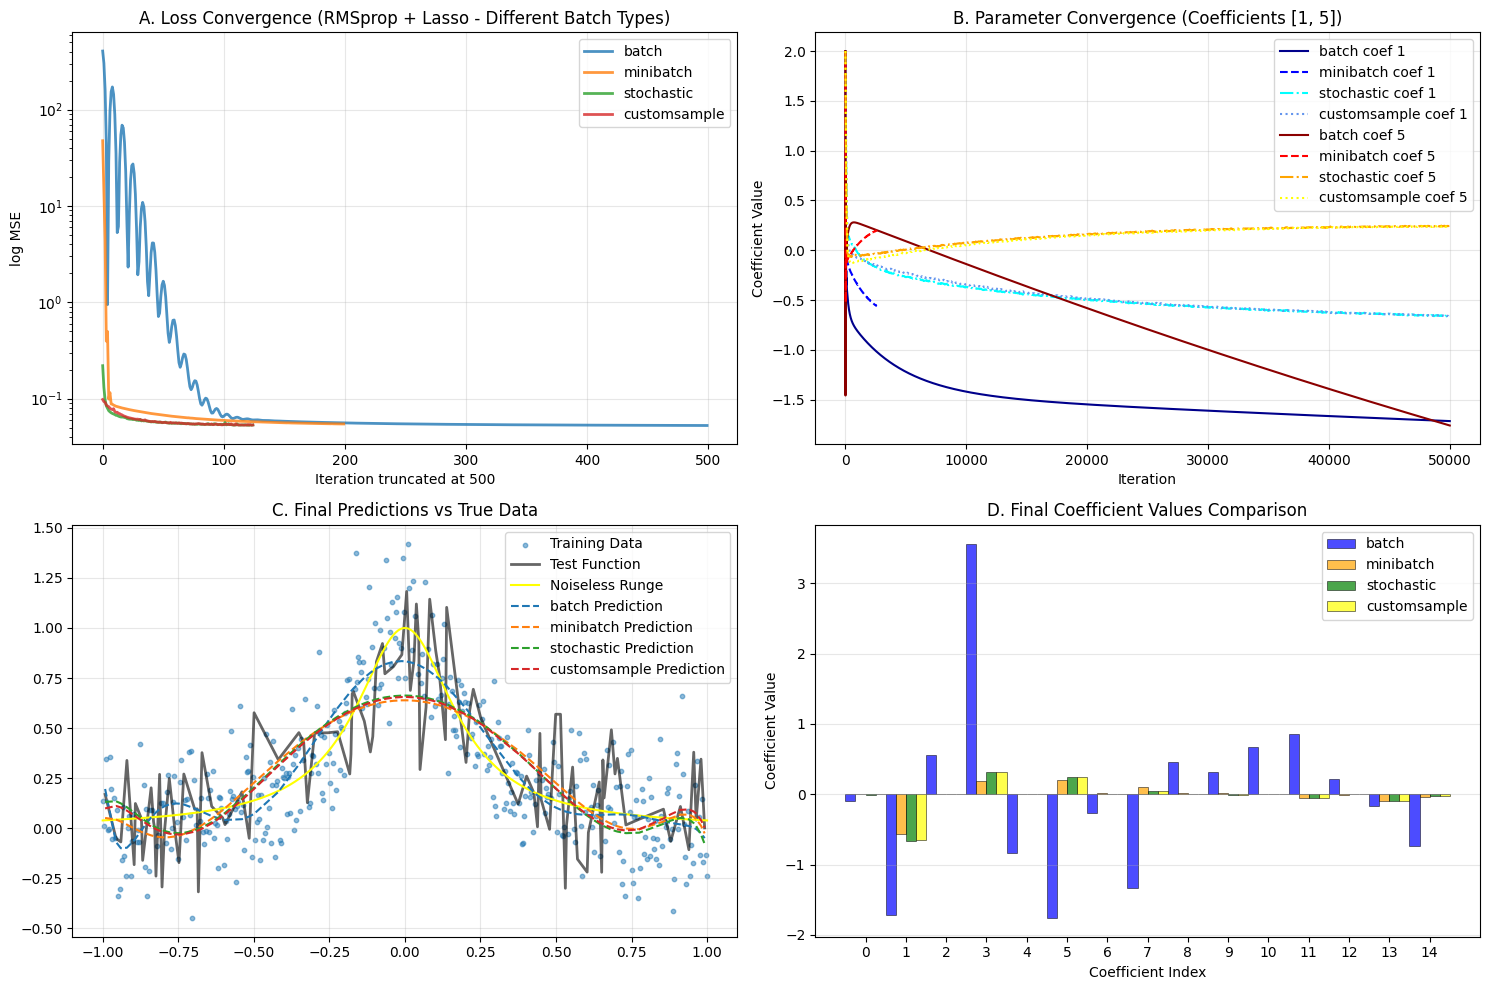

In [203]:
# =================================================================================================
# 1. Plot Loss Convergence
# =================================================================================================

plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
for key, losses in loss_log.items():
    plt.plot(losses[:500], label=key, alpha=0.8, linewidth=2)

plt.xlabel('Iteration truncated at 500')
plt.ylabel('log MSE')
plt.title('A. Loss Convergence (RMSprop + Lasso - Different Batch Types)')
plt.yscale('log')
plt.legend()
plt.grid(True, alpha=0.3)

# =================================================================================================
# 2. Plot Parameter Convergence (specific coefficients)
# =================================================================================================

coefficients_to_plot = [1, 5]  # Specify which coefficients to track
plt.subplot(2, 2, 2)

# Define color schemes for each coefficient
color_schemes = {
    0: ['darkblue', 'blue', 'cyan', 'cornflowerblue'],  # Blue tones for coefficient 1
    1: ['darkred', 'red', 'orange', 'yellow']           # Red tones for coefficient 2
}

line_styles = {'batch': '-', 'minibatch': '--', 'stochastic': '-.', 'customsample': ':'}

for i, coef_idx in enumerate(coefficients_to_plot):
    for j, (key, coef_history) in enumerate(theta_log.items()):
        if coef_idx < len(coef_history[0]):
            coef_values = [coef[coef_idx] for coef in coef_history]
            color = color_schemes[i][j % len(color_schemes[i])]
            ls = line_styles[key]
            plt.plot(coef_values, label=f'{key} coef {coef_idx}', 
                    alpha=1, ls=ls, linewidth=1.5, color=color)

plt.xlabel('Iteration')
plt.ylabel('Coefficient Value')
plt.title(f'B. Parameter Convergence (Coefficients {[x for x in coefficients_to_plot]})')
plt.legend()
plt.grid(True, alpha=0.3)

# =================================================================================================
# 3. Plot Final Predictions vs True Data
# =================================================================================================

plt.subplot(2, 2, 3)
sort_idx = np.argsort(x_test)
x_test_sorted = x_test[sort_idx]
y_test_sorted = y_test[sort_idx]

plt.scatter(x_train, y_sc + y_offset, alpha=0.5, label='Training Data', s=10)
plt.plot(x_test_sorted, y_test_sorted, 'k-', linewidth=2, label='Test Function', alpha=0.6)
plot_xaxis2, plot_yaxis2 = runge_function(N, False)
plt.plot(plot_xaxis2, plot_yaxis2, label='Noiseless Runge', color='yellow')

for key, model in models.items():
    y_pred_test = model.predict(X_test_scaled, y_offset)
    y_pred_test_sorted = y_pred_test[sort_idx]
    plt.plot(x_test_sorted, y_pred_test_sorted, '--', linewidth=1.5, label=f'{key} Prediction')

plt.title('C. Final Predictions vs True Data')
plt.legend()
plt.grid(True, alpha=0.3)

# =================================================================================================
# 4. Plot Final Coefficients Comparison
# =================================================================================================

plt.subplot(2, 2, 4)

n_coefs = len(models['batch'].coef_)
x_pos = np.arange(n_coefs)
bar_width = 0.25  # Width of each bar

# Create positions for each method's bars
positions = []
keys = list(models.keys())
for i, key in enumerate(keys):
    positions.append(x_pos + i * bar_width)

# Plot bars for each method
colors = ['blue', 'orange', 'green', 'yellow']
for i, (key, model) in enumerate(models.items()):
    plt.bar(positions[i], model.coef_, width=bar_width, 
            label=key, alpha=0.7, color=colors[i], edgecolor='black', linewidth=0.5)

plt.xlabel('Coefficient Index')
plt.ylabel('Coefficient Value')
plt.title('D. Final Coefficient Values Comparison')
plt.legend()
plt.grid(True, alpha=0.3, axis='y')

# Set x-ticks to be in the middle of each group
plt.xticks(x_pos + bar_width * (len(keys) - 1) / 2, x_pos)

plt.tight_layout()
plt.savefig(rf"{figpath}\SDG_batches_momentum.png")
plt.show()

minibatch needs to fine tune lr/sample size, epoch cant be too small
mementum SDG needs smaller lr by a mag

If RMSprop then minibatch cant have too many epoch

IF adam or RMSprop then Lasso/Ridge or Ols doesnt matter when stochastic

If minibatches than you need either batch size 64 and 50 is optimal, if other batchnumber 100 or backsize larger/smaller then it starts to diverge the MSE

Momentum and Adagrad are not compatible with SDG (need exp damping for momentum)

### part G

Perform then a bias-variance analysis of the Runge function by studying the MSE and Bias/Variance value as function of the complexity of your model and the size of the model (with bootstrap)

In [204]:
def get_bias(y_true, y_pred):
    f_bar = np.mean(y_pred, axis=0)
    return np.mean((f_bar - y_true)**2)

def get_var(y_pred):
    f_bar = np.mean(y_pred, axis=0)
    return np.mean((f_bar - y_pred)**2)

def get_mse(y_true, y_pred):
    return np.mean((y_pred - y_true.reshape(1, -1))**2)

### Bias-Variance Tradeoff function of Complexity for **OLS**. First method (using my prepcoessing and slicing it)

In [205]:
N = 50
bootstraps = 100
P1 = 13
np.random.seed(42)

x, y = runge_function(N, noise=True)
#generate the big FM with max degree (in loop we slice it)
X_train_scaled, X_test_scaled, bip, boop, y_sc, y_offset, y_test, max_eig = pre_processing(x, y, N, P1)

bias_vec1, var_vec1, mse_vec1 = [], [], []
for p in range(1, P1+1):
    predictions = np.zeros((bootstraps, len(y_test)))

    for b in range(bootstraps):
        # Resample with replacement using first p features
        X_train_re, y_train_re = resample(X_train_scaled[:, :p], y_sc)
        theta_OLS = OLS_params(X_train_re, y_train_re)
        # Predict on test set (first p features)
        y_test_pred = X_test_scaled[:, :p] @ theta_OLS + y_offset
        predictions[b, :] = y_test_pred.ravel()

    # Bias–variance–MSE decomposition  (y_test here is the one outside the b and p loop!)
    bias_vec1.append(get_bias(y_test, predictions))
    var_vec1.append(get_var(predictions))
    mse_vec1.append(get_mse(y_test, predictions))
    
#==================================================================================================================
#==================================================================================================================

N = 160
bootstraps = 600
P2 = 17

# N = 250
# bootstraps = 1200
# P2 = 42

np.random.seed(42)

x, y = runge_function(N, noise=True)
#generate the big FM with max degree (in loop we slice it)
X_train_scaled, X_test_scaled, bip, boop, y_sc, y_offset, y_test, max_eig = pre_processing(x, y, N, P2)

bias_vec2, var_vec2, mse_vec2 = [], [], []
for p in range(1, P2+1):
    predictions = np.zeros((bootstraps, len(y_test)))

    for b in range(bootstraps):
        # Resample with replacement using first p features
        X_train_re, y_train_re = resample(X_train_scaled[:, :p], y_sc)
        theta_OLS = OLS_params(X_train_re, y_train_re)
        # Predict on test set (first p features)
        y_test_pred = X_test_scaled[:, :p] @ theta_OLS + y_offset
        predictions[b, :] = y_test_pred.ravel()

    # Bias–variance–MSE decomposition  (y_test here is the one outside the b and p loop!)
    bias_vec2.append(get_bias(y_test, predictions))
    var_vec2.append(get_var(predictions))
    mse_vec2.append(get_mse(y_test, predictions))

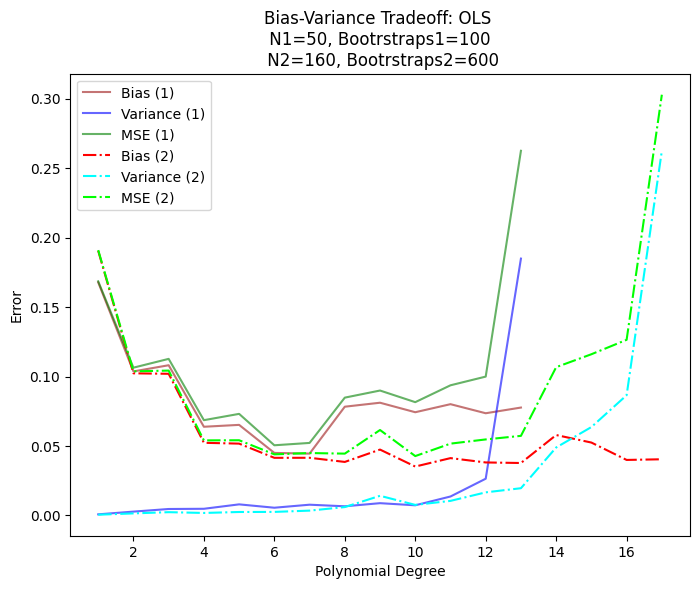

In [206]:
from scipy.ndimage import uniform_filter1d
bias_vec1 = np.array(bias_vec1)
var_vec1 = np.array(var_vec1)
mse_vec1 = np.array(mse_vec1)

bias_vec2 = np.array(bias_vec2)
var_vec2 = np.array(var_vec2)
mse_vec2 = np.array(mse_vec2)

# smooth out the curves, running average with next neightbour size=2
# bias_smooth = uniform_filter1d(bias_vec, size=2)
# var_smooth  = uniform_filter1d(var_vec, size=2)
# mse_smooth  = uniform_filter1d(mse_vec, size=2)

plt.figure(figsize=(8,6))
plt.plot(range(1, P1+1), bias_vec1, label="Bias (1)", color='brown', alpha=0.65)
# plt.plot(range(1, P+1), bias_smooth, color='orange',ls='--', alpha=0.9)
plt.plot(range(1, P1+1), var_vec1, label="Variance (1)", color='blue', alpha=0.6)
# plt.plot(range(1, P+1), var_smooth, color='cyan',ls='--', alpha=0.9)
# plt.plot(range(1, P1+1), bias_vec1 + var_vec1, ls='-',label="Bias+Variance (1)", color='black', alpha=0.5) 
plt.plot(range(1, P1+1), mse_vec1, ls='-', label="MSE (1)", color='green', alpha=0.6)


plt.plot(range(1, P2+1), bias_vec2, label="Bias (2)", color='red',ls='-.', alpha=1)
# plt.plot(range(1, P+1), bias_smooth, color='orange',ls='--', alpha=0.9)
plt.plot(range(1, P2+1), var_vec2, label="Variance (2)", ls='-.', color='cyan', alpha=1)
# plt.plot(range(1, P+1), var_smooth, color='cyan',ls='--', alpha=0.9)
# plt.plot(range(1, P2+1), bias_vec2 + var_vec2, ls='-',label="Bias+Variance (2)", color='grey', alpha=0.5) 
plt.plot(range(1, P2+1), mse_vec2, ls='-.', label="MSE (2)", color='lime', alpha=1)

# plt.plot(range(1, P+1), mse_smooth, color='lime',ls='--', alpha=0.9)
plt.xlabel("Polynomial Degree")
plt.ylabel("Error")
plt.legend()
plt.title(f"Bias-Variance Tradeoff: OLS \n N1={50}, Bootrstraps1=100 \n N2={160}, Bootrstraps2=600")
plt.savefig(rf"{figpath}\biasvar_complexity_ols.png")
plt.show()

### Bias-Variance as function of Data Sample for **OLS**

In [207]:
N = 500
P = 20
bootstraps = 500
np.random.seed(42)

x, y = runge_function(N, noise=True)
#generate the big FM with max degree (in loop we slice it)
X_train_scaled, X_test_scaled, bip, boop, y_sc, y_offset, y_test, max_eig = pre_processing(x, y, N, P)

n_values = np.arange(50, N, 25)
bias_vec, var_vec, mse_vec = [], [], []
for n in n_values:
    predictions = np.zeros((bootstraps, len(y_test[:n])))
    for b in range(bootstraps):
        # Resample with replacement using first n rows
        X_train_re, y_train_re = resample(X_train_scaled[:n, :], y_sc[:n])    
        theta_OLS = OLS_params(X_train_re, y_train_re)
        # Predict on test set (first p features) change this from p to n 
        y_test_pred = X_test_scaled[:n, :] @ theta_OLS + y_offset
        predictions[b, :] = y_test_pred.ravel()

    # Bias–variance–MSE decomposition  (y_test here is the one outside the b and p loop!)
    bias_vec.append(get_bias(y_test[:n], predictions))
    var_vec.append(get_var(predictions))
    mse_vec.append(get_mse(y_test[:n], predictions))
    
bias_vec1 = np.array(bias_vec)
var_vec1 = np.array(var_vec)

P = 10
X_train_scaled, X_test_scaled, bip, boop, y_sc, y_offset, y_test, max_eig = pre_processing(x, y, N, P)

bias_vec, var_vec, mse_vec = [], [], []
for n in n_values:
    predictions = np.zeros((bootstraps, len(y_test[:n])))
    for b in range(bootstraps):
        # Resample with replacement using first n rows
        X_train_re, y_train_re = resample(X_train_scaled[:n, :], y_sc[:n])    
        theta_OLS = OLS_params(X_train_re, y_train_re)
        # Predict on test set (first p features) change this from p to n 
        y_test_pred = X_test_scaled[:n, :] @ theta_OLS + y_offset
        predictions[b, :] = y_test_pred.ravel()

    # Bias–variance–MSE decomposition  (y_test here is the one outside the b and p loop!)
    bias_vec.append(get_bias(y_test[:n], predictions))
    var_vec.append(get_var(predictions))
    mse_vec.append(get_mse(y_test[:n], predictions))
    
bias_vec2 = np.array(bias_vec)
var_vec2 = np.array(var_vec)

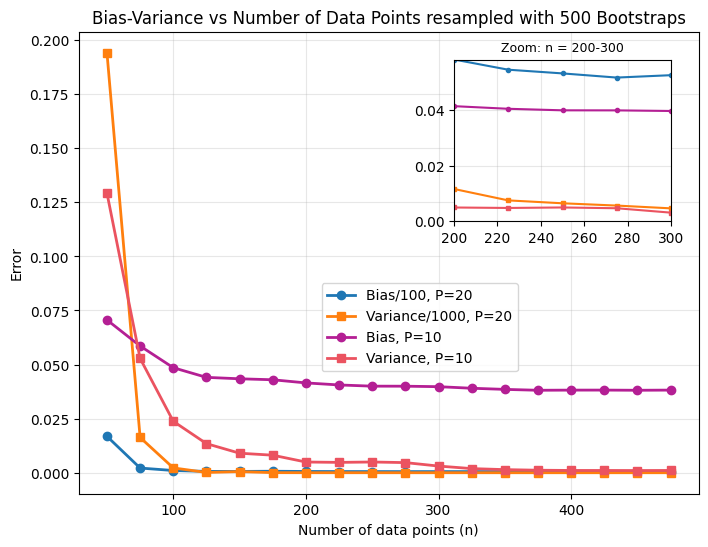

In [208]:
plt.figure(figsize=(8, 6)) 

scale = 100

# Main plot
main_ax = plt.gca()
main_ax.plot(n_values, bias_vec1/scale, marker='o', label='Bias/100, P=20', linewidth=2, color='#1f77b4')
main_ax.plot(n_values, var_vec1/scale/10, marker='s', label=f'Variance/1000, P=20', linewidth=2, color='#ff7f0e')

main_ax.plot(n_values, bias_vec2, marker='o', label='Bias, P=10', linewidth=2, color="#b41f94")
main_ax.plot(n_values, var_vec2, marker='s', label=f'Variance, P=10', linewidth=2, color="#eb5360")

main_ax.set_xlabel("Number of data points (n)")
main_ax.set_ylabel("Error")
main_ax.set_title(f"Bias-Variance vs Number of Data Points resampled with {bootstraps} Bootstraps")
main_ax.legend(loc='lower center', bbox_to_anchor=(0.55, 0.25))
main_ax.grid(True, alpha=0.3)

x_zoom_min = 200
x_zoom_max = 300 
y_zoom_min = 0
zoom_mask = (n_values >= x_zoom_min) & (n_values <= x_zoom_max)
max_bias_in_zoom = max(np.max(bias_vec1[zoom_mask]), np.max(bias_vec2[zoom_mask]))
max_var_in_zoom = max(np.max(var_vec1[zoom_mask]), np.max(var_vec2[zoom_mask]))
y_zoom_max = max(max_bias_in_zoom, max_var_in_zoom/scale)   

ax_inset = inset_axes(main_ax, 
                      width="35%",  
                      height="35%",  
                      loc='upper right',  
                      borderpad=2)

ax_inset.plot(n_values, bias_vec1, marker='o', label='Bias, P=20', linewidth=1.5, markersize=3, color='#1f77b4')
ax_inset.plot(n_values, var_vec1, marker='s', label=f'Variance, P=20', linewidth=1.5, markersize=3, color='#ff7f0e')
ax_inset.plot(n_values, bias_vec2, marker='o', label='Bias, P=10', linewidth=1.5, markersize=3, color='#b41f94')
ax_inset.plot(n_values, var_vec2, marker='s', label=f'Variance, P=10', linewidth=1.5, markersize=3, color='#eb5360')

ax_inset.set_xlim(x_zoom_min, x_zoom_max)
ax_inset.set_ylim(y_zoom_min, y_zoom_max)
ax_inset.grid(True, alpha=0.3)
ax_inset.set_title(F'Zoom: n = {x_zoom_min}-{x_zoom_max}', fontsize=9)
plt.savefig(rf"{figpath}\biasvar_dataset_ols.png")
plt.show()

### Bias-Variance Tradeoff function of Complexity. Second Method (using pipeline)

In [209]:
N = 500
bootstraps = 100
P = 36
np.random.seed(42)

x, y = runge_function(N, noise=True)
X_train, X_test, y_train, y_test = train_test_split(x.reshape(-1, 1), y, test_size=traintestrat)
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)
y_offset = np.mean(y_train)
y_sc = y_train - y_offset

bias_vec, var_vec, mse_vec = [], [], []
for p in range(1, P+1):
    predictions = np.zeros((bootstraps, len(y_test)))
    model = make_pipeline(PolynomialFeatures(degree=p, include_bias=False), LinearRegression(fit_intercept=False))
    for b in range(bootstraps):
        X_train_re, y_train_re = resample(X_train_scaled, y_sc) #the bootstrapping itself (reshuffle with replacement)
        predictions[b, :] = model.fit(X_train_re, y_train_re).predict(X_test_scaled).ravel()

    bias_vec.append(get_bias(np.asarray(y_test), predictions))
    var_vec.append(get_var(predictions))
    mse_vec.append(get_mse(np.asarray(y_test), predictions)) 

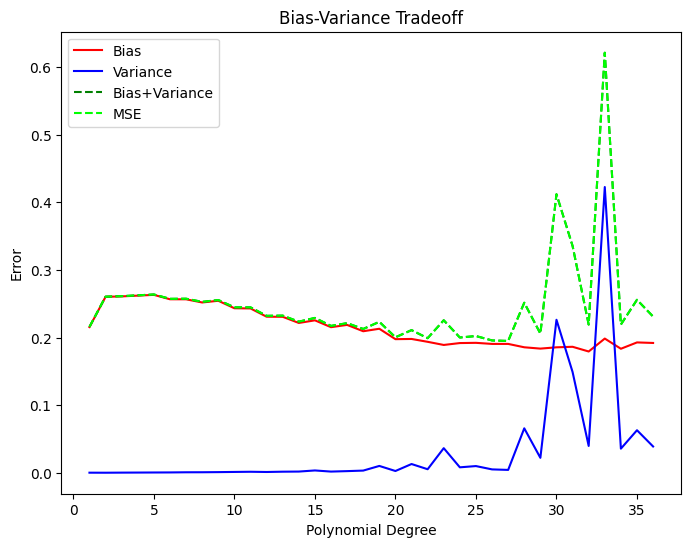

In [210]:
from scipy.ndimage import uniform_filter1d
bias_vec = np.array(bias_vec)
var_vec = np.array(var_vec)
mse_vec = np.array(mse_vec)
# smooth out the curves, running average with next neightbour size=2
bias_smooth = uniform_filter1d(bias_vec, size=2)
var_smooth  = uniform_filter1d(var_vec, size=2)
mse_smooth  = uniform_filter1d(mse_vec, size=2)

plt.figure(figsize=(8,6))
plt.plot(range(1, P+1), bias_vec, label="Bias", color='red')
plt.plot(range(1, P+1), var_vec, label="Variance", color='blue')
plt.plot(range(1, P+1), bias_vec + var_vec, ls='--',label="Bias+Variance", color='green') 
plt.plot(range(1, P+1), mse_vec, ls='--', label="MSE", color='lime')
plt.xlabel("Polynomial Degree")
plt.ylabel("Error")
plt.legend()
plt.title("Bias-Variance Tradeoff")
plt.show()

### Bias-Variance Tradeoff function of Complexity for **Ridge**. First method (using my prepcoessing and slicing it)

In [211]:
N = 160
bootstraps = 600
P = 25
l_val = 1e-5
np.random.seed(42)

x, y = runge_function(N, noise=True)
#generate the big FM with max degree (in loop we slice it)
X_train_scaled, X_test_scaled, bip, boop, y_sc, y_offset, y_test, max_eig = pre_processing(x, y, N, P)

bias_vec, var_vec, mse_vec = [], [], []
for p in range(1, P+1):
    predictions = np.zeros((bootstraps, len(y_test)))

    for b in range(bootstraps):
        # Resample with replacement using first p features
        X_train_re, y_train_re = resample(X_train_scaled[:, :p], y_sc)
        theta_Ridge = Ridge_params(X_train_re, y_train_re, l_val)
        # Predict on test set (first p features)
        y_test_pred = X_test_scaled[:, :p] @ theta_Ridge + y_offset
        predictions[b, :] = y_test_pred.ravel()

    # Bias–variance–MSE decomposition  (y_test here is the one outside the b and p loop!)
    bias_vec.append(get_bias(y_test, predictions))
    var_vec.append(get_var(predictions))
    mse_vec.append(get_mse(y_test, predictions))

l_val = 1e-3
bias_vec3, var_vec3, mse_vec3 = [], [], []
for p in range(1, P+1):
    predictions = np.zeros((bootstraps, len(y_test)))

    for b in range(bootstraps):
        # Resample with replacement using first p features
        X_train_re, y_train_re = resample(X_train_scaled[:, :p], y_sc)
        theta_Ridge = Ridge_params(X_train_re, y_train_re, l_val)
        # Predict on test set (first p features)
        y_test_pred = X_test_scaled[:, :p] @ theta_Ridge + y_offset
        predictions[b, :] = y_test_pred.ravel()

    # Bias–variance–MSE decomposition  (y_test here is the one outside the b and p loop!)
    bias_vec3.append(get_bias(y_test, predictions))
    var_vec3.append(get_var(predictions))
    mse_vec3.append(get_mse(y_test, predictions))

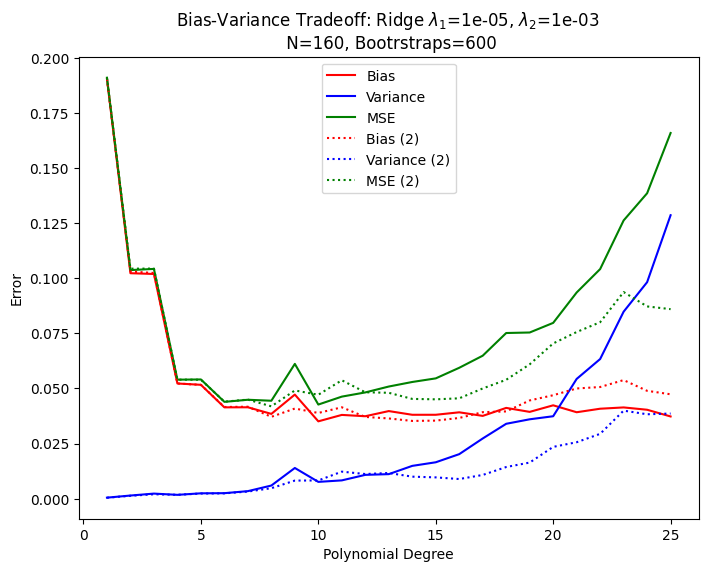

In [212]:
from scipy.ndimage import uniform_filter1d
bias_vec = np.array(bias_vec)
var_vec = np.array(var_vec)
mse_vec = np.array(mse_vec)

bias_vec3 = np.array(bias_vec3)
var_vec3 = np.array(var_vec3)
mse_vec3 = np.array(mse_vec3)


# smooth out the curves, running average with next neightbour size=2
# bias_smooth = uniform_filter1d(bias_vec, size=2)
# var_smooth  = uniform_filter1d(var_vec, size=2)
# mse_smooth  = uniform_filter1d(mse_vec, size=2)

plt.figure(figsize=(8,6))
plt.plot(range(1, P+1), bias_vec, label="Bias", color='red')
# plt.plot(range(1, P+1), bias_smooth, color='orange', alpha=0.5)
plt.plot(range(1, P+1), var_vec, label="Variance", color='blue')
# plt.plot(range(1, P+1), var_smooth, color='cyan', alpha=0.5)
# plt.plot(range(1, P+1), bias_vec3 + var_vec3, ls='-',label="Bias+Variance", color='yellow', alpha=0.6) 
plt.plot(range(1, P+1), mse_vec, ls='-', label="MSE", color='green', alpha=1)
# plt.plot(range(1, P+1), mse_smooth, color='lime', alpha=0.5)

plt.plot(range(1, P+1), bias_vec3, ls=':', label="Bias (2)", color='red')
plt.plot(range(1, P+1), var_vec3, ls=':', label="Variance (2)", color='blue')
plt.plot(range(1, P+1), mse_vec3, ls=':', label="MSE (2)", color='green', alpha=1)


plt.xlabel("Polynomial Degree")
plt.ylabel("Error")
plt.legend()
plt.title(f"Bias-Variance Tradeoff: Ridge $\lambda_1$=1e-05, $\lambda_2$=1e-03 \n N={N}, Bootrstraps=600")
plt.savefig(rf"{figpath}\biasvar_complexity_ridge.png")
plt.show()

### Bias-Variance as function of Data Sample for **Ridge**

In [213]:
N = 500
P = 59
bootstraps = 100
l_val = 1e-8
np.random.seed(42)

x, y = runge_function(N, noise=True)
#generate the big FM with max degree (in loop we slice it)
X_train_scaled, X_test_scaled, bip, boop, y_sc, y_offset, y_test, max_eig = pre_processing(x, y, N, P)

n_values = np.arange(50, N, 25)
bias_vec, var_vec, mse_vec = [], [], []
for n in n_values:
    predictions = np.zeros((bootstraps, len(y_test[:n])))
    for b in range(bootstraps):
        # Resample with replacement using first n rows
        X_train_re, y_train_re = resample(X_train_scaled[:n, :], y_sc[:n])    
        theta_Ridge = Ridge_params(X_train_re, y_train_re, l_val)
        # Predict on test set (first p features) change this from p to n 
        y_test_pred = X_test_scaled[:n, :] @ theta_Ridge + y_offset
        predictions[b, :] = y_test_pred.ravel()

    # Bias–variance–MSE decomposition  (y_test here is the one outside the b and p loop!)
    bias_vec.append(get_bias(y_test[:n], predictions))
    var_vec.append(get_var(predictions))
    mse_vec.append(get_mse(y_test[:n], predictions))
    
bias_vec1 = np.array(bias_vec)
var_vec1 = np.array(var_vec)

P = 30
X_train_scaled, X_test_scaled, bip, boop, y_sc, y_offset, y_test, max_eig = pre_processing(x, y, N, P)

bias_vec, var_vec, mse_vec = [], [], []
for n in n_values:
    predictions = np.zeros((bootstraps, len(y_test[:n])))
    for b in range(bootstraps):
        # Resample with replacement using first n rows
        X_train_re, y_train_re = resample(X_train_scaled[:n, :], y_sc[:n])    
        theta_Ridge = Ridge_params(X_train_re, y_train_re, l_val)
        # Predict on test set (first p features) change this from p to n 
        y_test_pred = X_test_scaled[:n, :] @ theta_Ridge + y_offset
        predictions[b, :] = y_test_pred.ravel()

    # Bias–variance–MSE decomposition  (y_test here is the one outside the b and p loop!)
    bias_vec.append(get_bias(y_test[:n], predictions))
    var_vec.append(get_var(predictions))
    mse_vec.append(get_mse(y_test[:n], predictions))
    
bias_vec2 = np.array(bias_vec)
var_vec2 = np.array(var_vec)

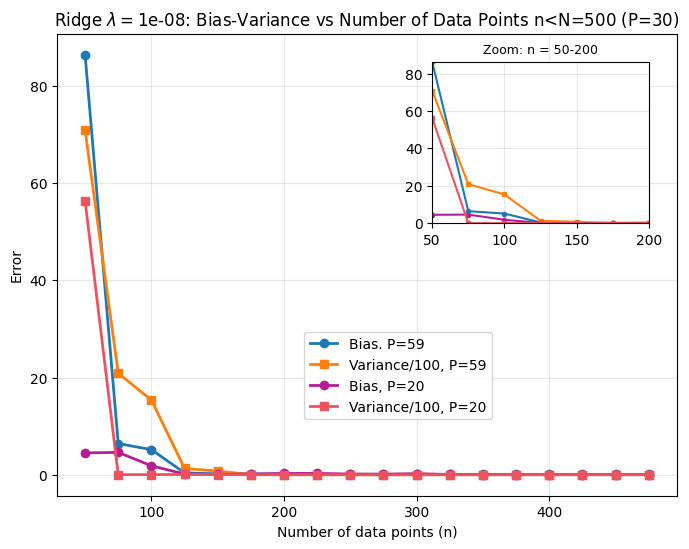

In [214]:
plt.figure(figsize=(8, 6)) 

scale = 100

# Main plot
main_ax = plt.gca()
main_ax.plot(n_values, bias_vec1, marker='o', label='Bias. P=59', linewidth=2, color='#1f77b4')
main_ax.plot(n_values, var_vec1/scale, marker='s', label=f'Variance/{scale}, P=59', linewidth=2, color='#ff7f0e')

main_ax.plot(n_values, bias_vec2, marker='o', label='Bias, P=20', linewidth=2, color="#b41f94")
main_ax.plot(n_values, var_vec2/scale, marker='s', label=f'Variance/{scale}, P=20', linewidth=2, color="#eb5360")

main_ax.set_xlabel("Number of data points (n)")
main_ax.set_ylabel("Error")
main_ax.set_title(rf"Ridge $\lambda=${l_val}: Bias-Variance vs Number of Data Points n<N={N} (P={P})")
main_ax.legend(loc='lower center', bbox_to_anchor=(0.55, 0.15))
main_ax.grid(True, alpha=0.3)

x_zoom_min = 50
x_zoom_max = 200 
y_zoom_min = 0
zoom_mask = (n_values >= x_zoom_min) & (n_values <= x_zoom_max)
max_bias_in_zoom = max(np.max(bias_vec1[zoom_mask]), np.max(bias_vec2[zoom_mask]))
max_var_in_zoom = max(np.max(var_vec1[zoom_mask]), np.max(var_vec2[zoom_mask]))
y_zoom_max = max(max_bias_in_zoom, max_var_in_zoom/scale)   

ax_inset = inset_axes(main_ax, 
                      width="35%",  
                      height="35%",  
                      loc='upper right',  
                      borderpad=2)

ax_inset.plot(n_values, bias_vec1, marker='o', label='Bias, P=59', linewidth=1.5, markersize=3, color='#1f77b4')
ax_inset.plot(n_values, var_vec1/scale, marker='s', label=f'Variance/{scale}, P=59', linewidth=1.5, markersize=3, color='#ff7f0e')
ax_inset.plot(n_values, bias_vec2, marker='o', label='Bias, P=20', linewidth=1.5, markersize=3, color='#b41f94')
ax_inset.plot(n_values, var_vec2/100, marker='s', label=f'Variance/{scale}, P=20', linewidth=1.5, markersize=3, color='#eb5360')

ax_inset.set_xlim(x_zoom_min, x_zoom_max)
ax_inset.set_ylim(y_zoom_min, y_zoom_max)
ax_inset.grid(True, alpha=0.3)
ax_inset.set_title(F'Zoom: n = {x_zoom_min}-{x_zoom_max}', fontsize=9)  
plt.savefig(rf"{figpath}\biasvar_datasample_ridge.png")
plt.show()

### part H

k-fold cross validation (next week), Scikit learn
evaluate MSEW function from the test folds
Compare with the boostrap method

do all this also using Ridge and Lasso

In [215]:
N = 200
k_folds = 10  # Number of folds for cross-validation
P = 20
l_val = 1e-5
np.random.seed(42)

x, y = runge_function(N, noise=True)

FM = polynomial_features(x, P, intercept=interceptFit)
FM_mean = FM.mean(axis=0)
FM_std = FM.std(axis=0)
FM_std[FM_std == 0] = 1  # safeguard to avoid division by zero for constant features
FM_sc = (FM - FM_mean) / FM_std

mse_ols_Pvec = []
mse_ridge_Pvec = []  # store MSE for each p degree

for p in range(1, P+1):
    X_p = FM_sc[:, :p] # Use only first p features
    kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)
    
    mse_ols_Kvec = []  # sotore MSE for each fold
    mse_ridge_Kvec = []  
    
    for train_index, test_index in kf.split(X_p):
        # Split data into training and test sets for this fold
        X_train, X_test = X_p[train_index], X_p[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        # Scale Data
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        y_offset = y_train.mean()
        y_train_scaled = y_train - y_offset
        
        # Get Predictions
        theta_OLS = OLS_params(X_train_scaled, y_train_scaled)
        theta_Ridge = Ridge_params(X_train_scaled, y_train_scaled, l_val)
        ols_y_test_pred = X_test_scaled @ theta_OLS + y_offset
        ridge_y_test_pred = X_test_scaled @ theta_Ridge + y_offset
        
        mse_ols_Kvec.append(get_mse(y_test, ols_y_test_pred))
        mse_ridge_Kvec.append(get_mse(y_test, ridge_y_test_pred))
        
    mse_ols_Pvec.append(np.mean(mse_ols_Kvec))
    mse_ridge_Pvec.append(np.mean(mse_ridge_Kvec))

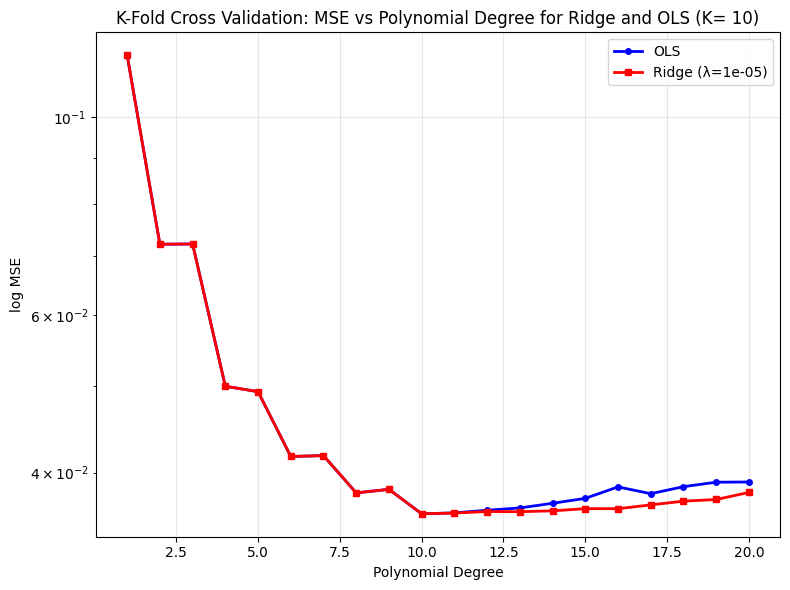

In [216]:
plt.figure(figsize=(8, 6))

# Polynomial degrees (x-axis)
degrees = np.arange(1, P+1)

plt.semilogy(degrees, mse_ols_Pvec, 'b-', linewidth=2, label='OLS', marker='o', markersize=4)
plt.semilogy(degrees, mse_ridge_Pvec, 'r-', linewidth=2, label=f'Ridge (λ={l_val})', marker='s', markersize=4)

plt.xlabel('Polynomial Degree')
plt.ylabel('log MSE')
plt.title(f'K-Fold Cross Validation: MSE vs Polynomial Degree for Ridge and OLS (K= {k_folds})')
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(rf"{figpath}\Kfold_complexity.png")
plt.show()